# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [34]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

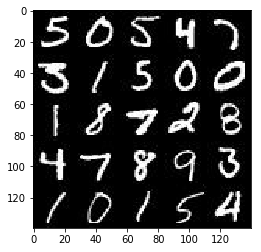

In [35]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

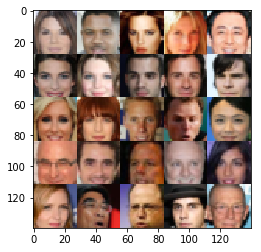

In [36]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [37]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [38]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), 
                                  name='real_input')
    z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [39]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = tf.placeholder(tf.float32)
    alpha = 0.2
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer 
        images_layer1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu_layer1 = tf.maximum(alpha * images_layer1, images_layer1)
        
        images_layer2 = tf.layers.conv2d(relu_layer1, 128, 5, strides=2, padding='same')
        batchnorm_layer2 = tf.layers.batch_normalization(images_layer2, training=True)
        relu_layer2 = tf.maximum(alpha * batchnorm_layer2, batchnorm_layer2)
        
        images_layer3 = tf.layers.conv2d(relu_layer2, 256, 5, strides=2, padding='same')
        batchnorm_layer3 = tf.layers.batch_normalization(images_layer3, training=True)
        relu_layer3 = tf.maximum(alpha * batchnorm_layer3, batchnorm_layer3)

        flat = tf.reshape(relu_layer3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [40]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = tf.placeholder(tf.float32)
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        z1 = tf.layers.dense(z, 7*7*256)

        z1 = tf.reshape(z1, (-1, 7, 7, 256))
        z1 = tf.layers.batch_normalization(z1, training=is_train)
        z1 = tf.maximum(alpha * z1, z1)
        
        z2 = tf.layers.conv2d_transpose(z1, 128, 5, strides=2, padding='same')
        z2 = tf.layers.batch_normalization(z2, training=is_train)
        z2 = tf.maximum(alpha * z2, z2)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(z2, out_channel_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [41]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    alpha = tf.placeholder(tf.float32)
    alpha = 0.2
    
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [42]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function

    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [43]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [44]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]

    # TODO: Build Model
    input_real, input_z, learn_rate = model_inputs(image_width, image_height, image_channels, z_dim)

    d_loss, g_loss = model_loss(input_real, input_z, image_channels)

    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learn_rate, beta1)
    
    samples, losses = [], []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images = batch_images*2
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={input_real:batch_images, 
                                                     input_z: batch_z,
                                                     learn_rate:learning_rate})
                _ = sess.run(g_train_opt, feed_dict={input_real:batch_images, 
                                                     input_z: batch_z, 
                                                     learn_rate:learning_rate})

                if steps % 10 == 0:

                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}: ".format(epoch_i+1, epoch_count),
                         "Discriminator Loss: {:.4f}".format(train_loss_d),
                         "Generator Loss: {:.4f}".format(train_loss_g))
                    

                if steps % 100 == 0:
                    show_generator_output(sess=sess, n_images = 10, input_z = input_z, 
                                          out_channel_dim = image_channels, image_mode = data_image_mode)
    
    return losses, samples
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2:  Discriminator Loss: 1.7691 Generator Loss: 1.9150
Epoch 1/2:  Discriminator Loss: 2.9266 Generator Loss: 3.9634
Epoch 1/2:  Discriminator Loss: 1.8005 Generator Loss: 3.2977
Epoch 1/2:  Discriminator Loss: 1.6242 Generator Loss: 2.2244
Epoch 1/2:  Discriminator Loss: 1.4584 Generator Loss: 1.9690
Epoch 1/2:  Discriminator Loss: 1.2980 Generator Loss: 1.5176
Epoch 1/2:  Discriminator Loss: 1.4595 Generator Loss: 1.7312
Epoch 1/2:  Discriminator Loss: 1.4502 Generator Loss: 1.6359
Epoch 1/2:  Discriminator Loss: 1.4271 Generator Loss: 1.3273
Epoch 1/2:  Discriminator Loss: 1.1421 Generator Loss: 1.2918


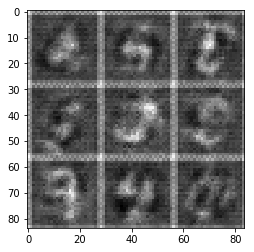

Epoch 1/2:  Discriminator Loss: 1.1670 Generator Loss: 1.2560
Epoch 1/2:  Discriminator Loss: 1.3395 Generator Loss: 1.3469
Epoch 1/2:  Discriminator Loss: 1.0237 Generator Loss: 1.1347
Epoch 1/2:  Discriminator Loss: 1.2521 Generator Loss: 1.5742
Epoch 1/2:  Discriminator Loss: 1.2304 Generator Loss: 1.6994
Epoch 1/2:  Discriminator Loss: 1.1139 Generator Loss: 1.6657
Epoch 1/2:  Discriminator Loss: 1.0409 Generator Loss: 1.3197
Epoch 1/2:  Discriminator Loss: 1.3708 Generator Loss: 1.6977
Epoch 1/2:  Discriminator Loss: 1.2823 Generator Loss: 1.7498
Epoch 1/2:  Discriminator Loss: 1.2339 Generator Loss: 1.7012


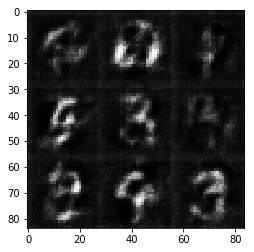

Epoch 1/2:  Discriminator Loss: 0.8354 Generator Loss: 1.1796
Epoch 1/2:  Discriminator Loss: 1.3689 Generator Loss: 0.3680
Epoch 1/2:  Discriminator Loss: 0.8543 Generator Loss: 1.3068
Epoch 1/2:  Discriminator Loss: 1.0117 Generator Loss: 1.6881
Epoch 1/2:  Discriminator Loss: 1.0183 Generator Loss: 1.7379
Epoch 1/2:  Discriminator Loss: 1.0801 Generator Loss: 1.7450
Epoch 1/2:  Discriminator Loss: 1.5900 Generator Loss: 2.9148
Epoch 1/2:  Discriminator Loss: 0.8578 Generator Loss: 1.3427
Epoch 1/2:  Discriminator Loss: 0.8673 Generator Loss: 1.2882
Epoch 1/2:  Discriminator Loss: 1.2000 Generator Loss: 2.2371


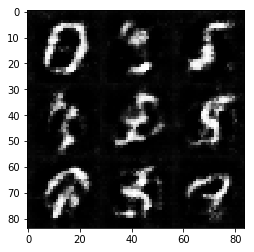

Epoch 1/2:  Discriminator Loss: 1.0168 Generator Loss: 0.9326
Epoch 1/2:  Discriminator Loss: 1.3959 Generator Loss: 1.9612
Epoch 1/2:  Discriminator Loss: 1.3724 Generator Loss: 0.3630
Epoch 1/2:  Discriminator Loss: 1.5519 Generator Loss: 0.3198
Epoch 1/2:  Discriminator Loss: 1.3090 Generator Loss: 0.4088
Epoch 1/2:  Discriminator Loss: 1.3355 Generator Loss: 0.3940
Epoch 1/2:  Discriminator Loss: 1.3410 Generator Loss: 0.3594
Epoch 1/2:  Discriminator Loss: 1.1967 Generator Loss: 0.4598
Epoch 1/2:  Discriminator Loss: 1.4495 Generator Loss: 0.3238
Epoch 1/2:  Discriminator Loss: 0.9957 Generator Loss: 1.3316


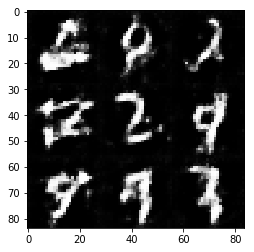

Epoch 1/2:  Discriminator Loss: 1.1544 Generator Loss: 0.4923
Epoch 1/2:  Discriminator Loss: 1.3060 Generator Loss: 0.4198
Epoch 1/2:  Discriminator Loss: 1.8341 Generator Loss: 0.2130
Epoch 1/2:  Discriminator Loss: 1.1771 Generator Loss: 0.5162
Epoch 1/2:  Discriminator Loss: 1.4982 Generator Loss: 0.3389
Epoch 1/2:  Discriminator Loss: 1.3781 Generator Loss: 0.3711
Epoch 1/2:  Discriminator Loss: 1.1131 Generator Loss: 1.6490
Epoch 1/2:  Discriminator Loss: 1.0571 Generator Loss: 1.5881
Epoch 1/2:  Discriminator Loss: 1.8136 Generator Loss: 0.2191
Epoch 1/2:  Discriminator Loss: 1.1512 Generator Loss: 0.5411


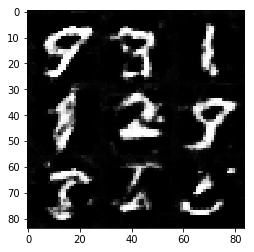

Epoch 1/2:  Discriminator Loss: 1.1699 Generator Loss: 1.7869
Epoch 1/2:  Discriminator Loss: 1.0898 Generator Loss: 1.5700
Epoch 1/2:  Discriminator Loss: 1.0134 Generator Loss: 1.6219
Epoch 1/2:  Discriminator Loss: 0.8899 Generator Loss: 1.1860
Epoch 1/2:  Discriminator Loss: 1.3948 Generator Loss: 0.3515
Epoch 1/2:  Discriminator Loss: 1.1192 Generator Loss: 0.5498
Epoch 1/2:  Discriminator Loss: 1.1998 Generator Loss: 0.4992
Epoch 1/2:  Discriminator Loss: 1.3731 Generator Loss: 0.3696
Epoch 1/2:  Discriminator Loss: 1.0847 Generator Loss: 0.6023
Epoch 1/2:  Discriminator Loss: 0.8377 Generator Loss: 0.8804


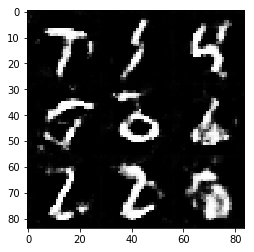

Epoch 1/2:  Discriminator Loss: 2.1855 Generator Loss: 0.1693
Epoch 1/2:  Discriminator Loss: 1.2202 Generator Loss: 0.4856
Epoch 1/2:  Discriminator Loss: 1.1115 Generator Loss: 0.5268
Epoch 1/2:  Discriminator Loss: 1.4845 Generator Loss: 0.3434
Epoch 1/2:  Discriminator Loss: 0.9965 Generator Loss: 0.8045
Epoch 1/2:  Discriminator Loss: 1.1716 Generator Loss: 1.7047
Epoch 1/2:  Discriminator Loss: 0.9779 Generator Loss: 1.3040
Epoch 1/2:  Discriminator Loss: 1.8181 Generator Loss: 0.2687
Epoch 1/2:  Discriminator Loss: 1.0779 Generator Loss: 0.8058
Epoch 1/2:  Discriminator Loss: 1.1394 Generator Loss: 0.4953


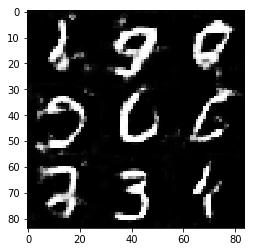

Epoch 1/2:  Discriminator Loss: 1.0762 Generator Loss: 0.5870
Epoch 1/2:  Discriminator Loss: 1.2469 Generator Loss: 0.4410
Epoch 1/2:  Discriminator Loss: 1.1005 Generator Loss: 0.5880
Epoch 1/2:  Discriminator Loss: 1.4756 Generator Loss: 0.3329
Epoch 1/2:  Discriminator Loss: 1.0869 Generator Loss: 0.5501
Epoch 1/2:  Discriminator Loss: 1.3903 Generator Loss: 0.3844
Epoch 1/2:  Discriminator Loss: 1.0504 Generator Loss: 0.5900
Epoch 1/2:  Discriminator Loss: 1.1814 Generator Loss: 0.5822
Epoch 1/2:  Discriminator Loss: 1.5829 Generator Loss: 0.3321
Epoch 1/2:  Discriminator Loss: 1.2685 Generator Loss: 0.4139


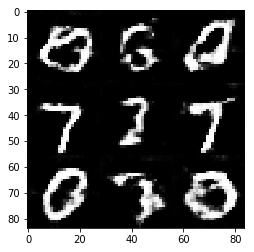

Epoch 1/2:  Discriminator Loss: 1.1236 Generator Loss: 0.5108
Epoch 1/2:  Discriminator Loss: 0.7751 Generator Loss: 0.8802
Epoch 1/2:  Discriminator Loss: 1.2846 Generator Loss: 0.4194
Epoch 1/2:  Discriminator Loss: 1.2978 Generator Loss: 0.4224
Epoch 1/2:  Discriminator Loss: 0.9859 Generator Loss: 0.5754
Epoch 1/2:  Discriminator Loss: 0.7426 Generator Loss: 1.0402
Epoch 1/2:  Discriminator Loss: 1.4109 Generator Loss: 2.5045
Epoch 1/2:  Discriminator Loss: 0.6583 Generator Loss: 1.3675
Epoch 1/2:  Discriminator Loss: 1.3193 Generator Loss: 0.3698
Epoch 1/2:  Discriminator Loss: 1.4954 Generator Loss: 0.3061


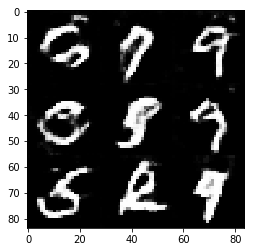

Epoch 1/2:  Discriminator Loss: 0.8567 Generator Loss: 0.7206
Epoch 1/2:  Discriminator Loss: 2.1400 Generator Loss: 0.1561
Epoch 1/2:  Discriminator Loss: 0.9002 Generator Loss: 1.2468
Epoch 1/2:  Discriminator Loss: 1.2638 Generator Loss: 0.3895
Epoch 1/2:  Discriminator Loss: 1.2234 Generator Loss: 0.4596
Epoch 1/2:  Discriminator Loss: 1.5341 Generator Loss: 0.3135
Epoch 1/2:  Discriminator Loss: 0.9775 Generator Loss: 0.6695
Epoch 1/2:  Discriminator Loss: 1.7094 Generator Loss: 0.2625
Epoch 1/2:  Discriminator Loss: 1.1469 Generator Loss: 1.9389
Epoch 1/2:  Discriminator Loss: 1.4273 Generator Loss: 1.9618


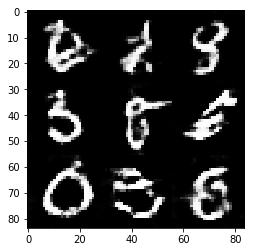

Epoch 1/2:  Discriminator Loss: 1.1411 Generator Loss: 0.4910
Epoch 1/2:  Discriminator Loss: 0.9106 Generator Loss: 0.7473
Epoch 1/2:  Discriminator Loss: 0.8826 Generator Loss: 1.2683
Epoch 1/2:  Discriminator Loss: 0.9263 Generator Loss: 0.7743
Epoch 1/2:  Discriminator Loss: 1.0972 Generator Loss: 0.5391
Epoch 1/2:  Discriminator Loss: 1.3470 Generator Loss: 0.4282
Epoch 1/2:  Discriminator Loss: 1.2802 Generator Loss: 0.3993
Epoch 1/2:  Discriminator Loss: 1.0171 Generator Loss: 0.6289
Epoch 1/2:  Discriminator Loss: 1.9177 Generator Loss: 2.9011
Epoch 1/2:  Discriminator Loss: 0.6987 Generator Loss: 1.3171


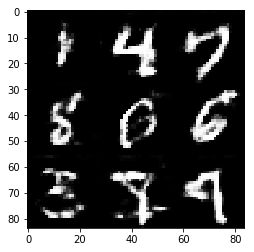

Epoch 1/2:  Discriminator Loss: 1.4490 Generator Loss: 0.3887
Epoch 1/2:  Discriminator Loss: 0.7999 Generator Loss: 1.0642
Epoch 1/2:  Discriminator Loss: 1.5937 Generator Loss: 0.3481
Epoch 1/2:  Discriminator Loss: 0.9605 Generator Loss: 0.6130
Epoch 1/2:  Discriminator Loss: 1.9557 Generator Loss: 0.2088
Epoch 1/2:  Discriminator Loss: 0.6964 Generator Loss: 0.9158
Epoch 1/2:  Discriminator Loss: 1.0212 Generator Loss: 0.5933
Epoch 1/2:  Discriminator Loss: 1.9548 Generator Loss: 0.2346
Epoch 1/2:  Discriminator Loss: 0.6298 Generator Loss: 1.1214
Epoch 1/2:  Discriminator Loss: 0.9407 Generator Loss: 1.7014


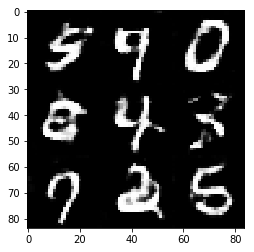

Epoch 1/2:  Discriminator Loss: 1.1195 Generator Loss: 0.5133
Epoch 1/2:  Discriminator Loss: 0.5892 Generator Loss: 1.1421
Epoch 1/2:  Discriminator Loss: 0.5787 Generator Loss: 1.2031
Epoch 1/2:  Discriminator Loss: 0.9170 Generator Loss: 1.9331
Epoch 1/2:  Discriminator Loss: 0.9401 Generator Loss: 1.4351
Epoch 1/2:  Discriminator Loss: 1.0759 Generator Loss: 1.6171
Epoch 1/2:  Discriminator Loss: 0.7998 Generator Loss: 0.8436
Epoch 1/2:  Discriminator Loss: 1.5593 Generator Loss: 0.3618
Epoch 1/2:  Discriminator Loss: 1.1087 Generator Loss: 0.5459
Epoch 1/2:  Discriminator Loss: 0.8692 Generator Loss: 0.6739


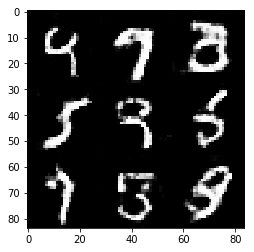

Epoch 1/2:  Discriminator Loss: 0.8351 Generator Loss: 2.0379
Epoch 1/2:  Discriminator Loss: 0.7394 Generator Loss: 0.9742
Epoch 1/2:  Discriminator Loss: 1.2867 Generator Loss: 0.5339
Epoch 1/2:  Discriminator Loss: 0.8145 Generator Loss: 0.8362
Epoch 1/2:  Discriminator Loss: 1.0367 Generator Loss: 1.8104
Epoch 1/2:  Discriminator Loss: 0.7994 Generator Loss: 0.9742
Epoch 1/2:  Discriminator Loss: 0.6037 Generator Loss: 1.7129
Epoch 1/2:  Discriminator Loss: 0.5852 Generator Loss: 1.5015
Epoch 1/2:  Discriminator Loss: 0.8038 Generator Loss: 0.7875
Epoch 1/2:  Discriminator Loss: 1.3783 Generator Loss: 2.5869


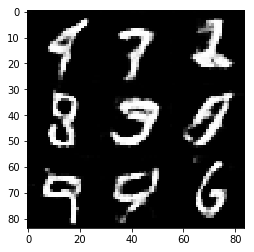

Epoch 1/2:  Discriminator Loss: 1.6922 Generator Loss: 0.3003
Epoch 1/2:  Discriminator Loss: 0.9718 Generator Loss: 0.6235
Epoch 1/2:  Discriminator Loss: 0.7275 Generator Loss: 0.8828
Epoch 1/2:  Discriminator Loss: 0.7461 Generator Loss: 0.8452
Epoch 1/2:  Discriminator Loss: 1.3128 Generator Loss: 3.6257
Epoch 1/2:  Discriminator Loss: 1.4737 Generator Loss: 0.3552
Epoch 1/2:  Discriminator Loss: 0.6767 Generator Loss: 1.0306
Epoch 1/2:  Discriminator Loss: 0.7456 Generator Loss: 0.8552
Epoch 1/2:  Discriminator Loss: 1.3250 Generator Loss: 2.6701
Epoch 1/2:  Discriminator Loss: 1.2832 Generator Loss: 0.4112


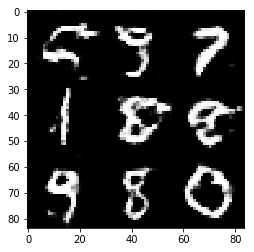

Epoch 1/2:  Discriminator Loss: 2.9888 Generator Loss: 0.0758
Epoch 1/2:  Discriminator Loss: 0.6469 Generator Loss: 1.2043
Epoch 1/2:  Discriminator Loss: 0.6790 Generator Loss: 1.0992
Epoch 1/2:  Discriminator Loss: 0.6838 Generator Loss: 1.0201
Epoch 1/2:  Discriminator Loss: 0.6813 Generator Loss: 0.9575
Epoch 1/2:  Discriminator Loss: 0.9766 Generator Loss: 0.6712
Epoch 1/2:  Discriminator Loss: 0.3480 Generator Loss: 1.8483
Epoch 1/2:  Discriminator Loss: 1.5683 Generator Loss: 3.5883
Epoch 1/2:  Discriminator Loss: 0.6355 Generator Loss: 1.4433
Epoch 1/2:  Discriminator Loss: 0.6820 Generator Loss: 1.9804


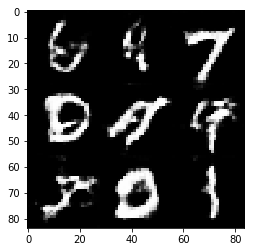

Epoch 1/2:  Discriminator Loss: 0.8008 Generator Loss: 1.4575
Epoch 1/2:  Discriminator Loss: 1.8817 Generator Loss: 0.2209
Epoch 1/2:  Discriminator Loss: 0.8361 Generator Loss: 0.7065
Epoch 1/2:  Discriminator Loss: 0.5263 Generator Loss: 1.1948
Epoch 1/2:  Discriminator Loss: 1.0881 Generator Loss: 0.5206
Epoch 1/2:  Discriminator Loss: 0.6893 Generator Loss: 0.9638
Epoch 1/2:  Discriminator Loss: 0.8532 Generator Loss: 0.7034
Epoch 1/2:  Discriminator Loss: 1.4417 Generator Loss: 0.3538
Epoch 1/2:  Discriminator Loss: 1.2669 Generator Loss: 0.4422
Epoch 1/2:  Discriminator Loss: 2.1662 Generator Loss: 0.1666


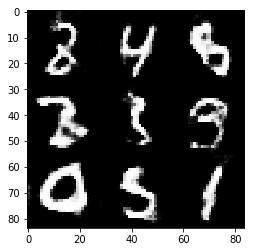

Epoch 1/2:  Discriminator Loss: 1.4583 Generator Loss: 0.4628
Epoch 1/2:  Discriminator Loss: 0.7211 Generator Loss: 0.9299
Epoch 1/2:  Discriminator Loss: 0.7480 Generator Loss: 0.9781
Epoch 1/2:  Discriminator Loss: 0.8053 Generator Loss: 0.7350
Epoch 1/2:  Discriminator Loss: 0.6317 Generator Loss: 1.1984
Epoch 1/2:  Discriminator Loss: 0.7019 Generator Loss: 1.8002
Epoch 1/2:  Discriminator Loss: 0.5272 Generator Loss: 1.3494
Epoch 1/2:  Discriminator Loss: 0.5551 Generator Loss: 1.6009
Epoch 1/2:  Discriminator Loss: 0.7484 Generator Loss: 1.1056
Epoch 1/2:  Discriminator Loss: 1.2329 Generator Loss: 0.4221


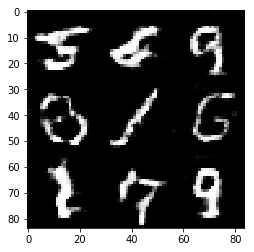

Epoch 1/2:  Discriminator Loss: 0.5545 Generator Loss: 1.2148
Epoch 1/2:  Discriminator Loss: 0.8073 Generator Loss: 0.8940
Epoch 1/2:  Discriminator Loss: 0.4270 Generator Loss: 1.8168
Epoch 1/2:  Discriminator Loss: 1.7127 Generator Loss: 0.2554
Epoch 1/2:  Discriminator Loss: 1.8767 Generator Loss: 0.2432
Epoch 1/2:  Discriminator Loss: 0.4825 Generator Loss: 1.2201
Epoch 1/2:  Discriminator Loss: 0.5066 Generator Loss: 1.3018
Epoch 2/2:  Discriminator Loss: 0.6296 Generator Loss: 0.9152
Epoch 2/2:  Discriminator Loss: 0.3081 Generator Loss: 2.0151
Epoch 2/2:  Discriminator Loss: 1.5699 Generator Loss: 3.2682


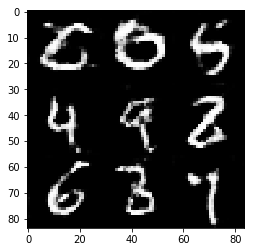

Epoch 2/2:  Discriminator Loss: 0.7617 Generator Loss: 2.2040
Epoch 2/2:  Discriminator Loss: 2.5961 Generator Loss: 0.1220
Epoch 2/2:  Discriminator Loss: 0.5985 Generator Loss: 1.9665
Epoch 2/2:  Discriminator Loss: 0.6111 Generator Loss: 1.0933
Epoch 2/2:  Discriminator Loss: 2.1071 Generator Loss: 0.1873
Epoch 2/2:  Discriminator Loss: 0.4785 Generator Loss: 1.3978
Epoch 2/2:  Discriminator Loss: 1.2119 Generator Loss: 3.6144
Epoch 2/2:  Discriminator Loss: 1.1679 Generator Loss: 0.5173
Epoch 2/2:  Discriminator Loss: 0.5867 Generator Loss: 2.5018
Epoch 2/2:  Discriminator Loss: 0.5075 Generator Loss: 1.4941


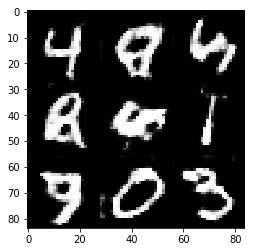

Epoch 2/2:  Discriminator Loss: 0.3062 Generator Loss: 2.0904
Epoch 2/2:  Discriminator Loss: 1.2539 Generator Loss: 3.5019
Epoch 2/2:  Discriminator Loss: 0.6823 Generator Loss: 1.0342
Epoch 2/2:  Discriminator Loss: 0.7479 Generator Loss: 0.8268
Epoch 2/2:  Discriminator Loss: 0.5140 Generator Loss: 1.1958
Epoch 2/2:  Discriminator Loss: 0.2475 Generator Loss: 2.0047
Epoch 2/2:  Discriminator Loss: 0.9351 Generator Loss: 0.6171
Epoch 2/2:  Discriminator Loss: 1.0286 Generator Loss: 0.6618
Epoch 2/2:  Discriminator Loss: 1.5957 Generator Loss: 3.1468
Epoch 2/2:  Discriminator Loss: 0.5419 Generator Loss: 2.0270


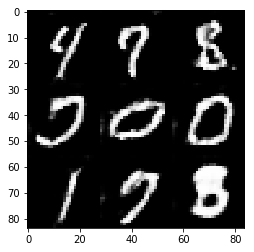

Epoch 2/2:  Discriminator Loss: 0.7104 Generator Loss: 2.2184
Epoch 2/2:  Discriminator Loss: 1.1228 Generator Loss: 0.5806
Epoch 2/2:  Discriminator Loss: 0.7682 Generator Loss: 0.8462
Epoch 2/2:  Discriminator Loss: 0.6251 Generator Loss: 1.0253
Epoch 2/2:  Discriminator Loss: 0.8306 Generator Loss: 0.7269
Epoch 2/2:  Discriminator Loss: 0.7390 Generator Loss: 0.9032
Epoch 2/2:  Discriminator Loss: 1.8712 Generator Loss: 0.2365
Epoch 2/2:  Discriminator Loss: 0.2233 Generator Loss: 2.0932
Epoch 2/2:  Discriminator Loss: 0.4640 Generator Loss: 1.2232
Epoch 2/2:  Discriminator Loss: 0.4397 Generator Loss: 1.2916


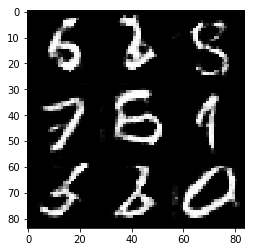

Epoch 2/2:  Discriminator Loss: 2.3436 Generator Loss: 0.2756
Epoch 2/2:  Discriminator Loss: 0.6781 Generator Loss: 1.4369
Epoch 2/2:  Discriminator Loss: 0.8578 Generator Loss: 3.3933
Epoch 2/2:  Discriminator Loss: 1.6391 Generator Loss: 0.3008
Epoch 2/2:  Discriminator Loss: 0.7854 Generator Loss: 0.8815
Epoch 2/2:  Discriminator Loss: 1.1215 Generator Loss: 0.5507
Epoch 2/2:  Discriminator Loss: 0.4848 Generator Loss: 1.2193
Epoch 2/2:  Discriminator Loss: 0.4601 Generator Loss: 1.3218
Epoch 2/2:  Discriminator Loss: 0.4788 Generator Loss: 2.3217
Epoch 2/2:  Discriminator Loss: 1.9131 Generator Loss: 0.3142


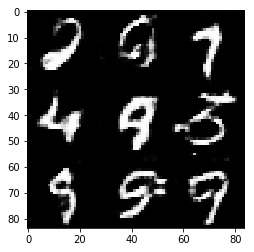

Epoch 2/2:  Discriminator Loss: 2.5479 Generator Loss: 0.1364
Epoch 2/2:  Discriminator Loss: 1.5830 Generator Loss: 0.3795
Epoch 2/2:  Discriminator Loss: 1.7895 Generator Loss: 0.2686
Epoch 2/2:  Discriminator Loss: 0.4657 Generator Loss: 1.9849
Epoch 2/2:  Discriminator Loss: 0.4269 Generator Loss: 1.3636
Epoch 2/2:  Discriminator Loss: 0.2695 Generator Loss: 1.7851
Epoch 2/2:  Discriminator Loss: 0.7754 Generator Loss: 0.9701
Epoch 2/2:  Discriminator Loss: 1.2554 Generator Loss: 0.5030
Epoch 2/2:  Discriminator Loss: 0.1301 Generator Loss: 2.6740
Epoch 2/2:  Discriminator Loss: 0.3364 Generator Loss: 1.5234


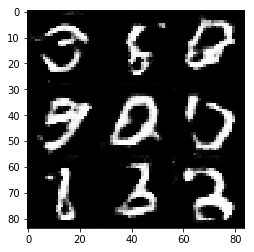

Epoch 2/2:  Discriminator Loss: 0.9885 Generator Loss: 0.5943
Epoch 2/2:  Discriminator Loss: 0.7777 Generator Loss: 0.8370
Epoch 2/2:  Discriminator Loss: 0.4298 Generator Loss: 1.2616
Epoch 2/2:  Discriminator Loss: 0.3153 Generator Loss: 1.6867
Epoch 2/2:  Discriminator Loss: 2.1422 Generator Loss: 0.2326
Epoch 2/2:  Discriminator Loss: 0.6427 Generator Loss: 1.1127
Epoch 2/2:  Discriminator Loss: 0.9943 Generator Loss: 0.6845
Epoch 2/2:  Discriminator Loss: 0.5156 Generator Loss: 1.8744
Epoch 2/2:  Discriminator Loss: 0.6051 Generator Loss: 1.4371
Epoch 2/2:  Discriminator Loss: 0.7313 Generator Loss: 1.1452


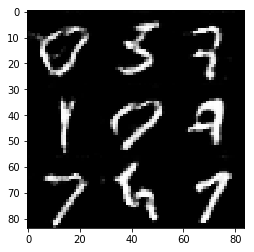

Epoch 2/2:  Discriminator Loss: 0.7674 Generator Loss: 0.8071
Epoch 2/2:  Discriminator Loss: 0.5203 Generator Loss: 1.1725
Epoch 2/2:  Discriminator Loss: 0.8773 Generator Loss: 0.7340
Epoch 2/2:  Discriminator Loss: 0.5508 Generator Loss: 1.3526
Epoch 2/2:  Discriminator Loss: 1.0056 Generator Loss: 0.6863
Epoch 2/2:  Discriminator Loss: 1.0627 Generator Loss: 0.5821
Epoch 2/2:  Discriminator Loss: 0.5509 Generator Loss: 1.1745
Epoch 2/2:  Discriminator Loss: 2.4657 Generator Loss: 4.7597
Epoch 2/2:  Discriminator Loss: 1.8771 Generator Loss: 4.6649
Epoch 2/2:  Discriminator Loss: 0.7239 Generator Loss: 1.0430


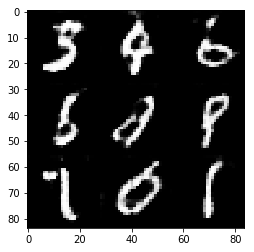

Epoch 2/2:  Discriminator Loss: 0.4199 Generator Loss: 1.4757
Epoch 2/2:  Discriminator Loss: 1.2421 Generator Loss: 0.4979
Epoch 2/2:  Discriminator Loss: 1.7022 Generator Loss: 3.9412
Epoch 2/2:  Discriminator Loss: 0.6027 Generator Loss: 1.0543
Epoch 2/2:  Discriminator Loss: 0.4246 Generator Loss: 1.5577
Epoch 2/2:  Discriminator Loss: 0.3416 Generator Loss: 1.5652
Epoch 2/2:  Discriminator Loss: 0.4916 Generator Loss: 1.8833
Epoch 2/2:  Discriminator Loss: 0.4658 Generator Loss: 2.8771
Epoch 2/2:  Discriminator Loss: 0.3957 Generator Loss: 2.1487
Epoch 2/2:  Discriminator Loss: 0.3377 Generator Loss: 2.1907


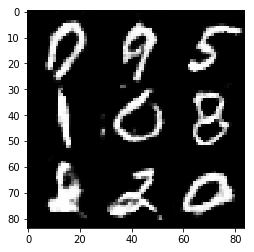

Epoch 2/2:  Discriminator Loss: 0.4680 Generator Loss: 1.3588
Epoch 2/2:  Discriminator Loss: 0.5786 Generator Loss: 1.1188
Epoch 2/2:  Discriminator Loss: 1.3888 Generator Loss: 0.5522
Epoch 2/2:  Discriminator Loss: 1.3493 Generator Loss: 3.9283
Epoch 2/2:  Discriminator Loss: 0.3139 Generator Loss: 2.1713
Epoch 2/2:  Discriminator Loss: 0.4243 Generator Loss: 1.9601
Epoch 2/2:  Discriminator Loss: 1.2468 Generator Loss: 0.5451
Epoch 2/2:  Discriminator Loss: 1.6575 Generator Loss: 0.3442
Epoch 2/2:  Discriminator Loss: 0.4028 Generator Loss: 1.3642
Epoch 2/2:  Discriminator Loss: 0.6103 Generator Loss: 1.1309


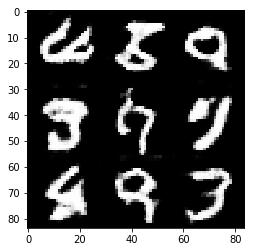

Epoch 2/2:  Discriminator Loss: 0.4419 Generator Loss: 4.0348
Epoch 2/2:  Discriminator Loss: 2.0878 Generator Loss: 5.1077
Epoch 2/2:  Discriminator Loss: 1.4660 Generator Loss: 0.4247
Epoch 2/2:  Discriminator Loss: 1.2748 Generator Loss: 0.5086
Epoch 2/2:  Discriminator Loss: 1.5695 Generator Loss: 0.3177
Epoch 2/2:  Discriminator Loss: 1.3412 Generator Loss: 0.4416
Epoch 2/2:  Discriminator Loss: 0.5563 Generator Loss: 1.7879
Epoch 2/2:  Discriminator Loss: 0.8881 Generator Loss: 0.7927
Epoch 2/2:  Discriminator Loss: 0.3622 Generator Loss: 2.5394
Epoch 2/2:  Discriminator Loss: 1.6337 Generator Loss: 0.3073


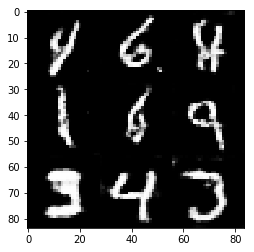

Epoch 2/2:  Discriminator Loss: 1.8682 Generator Loss: 0.2984
Epoch 2/2:  Discriminator Loss: 0.3700 Generator Loss: 1.8101
Epoch 2/2:  Discriminator Loss: 0.7123 Generator Loss: 0.9433
Epoch 2/2:  Discriminator Loss: 0.2669 Generator Loss: 2.0089
Epoch 2/2:  Discriminator Loss: 0.6357 Generator Loss: 0.9672
Epoch 2/2:  Discriminator Loss: 0.2537 Generator Loss: 1.8556
Epoch 2/2:  Discriminator Loss: 0.1527 Generator Loss: 2.3855
Epoch 2/2:  Discriminator Loss: 0.6415 Generator Loss: 1.2144
Epoch 2/2:  Discriminator Loss: 0.4447 Generator Loss: 3.1279
Epoch 2/2:  Discriminator Loss: 0.7134 Generator Loss: 0.9630


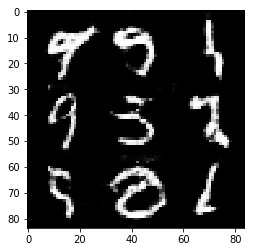

Epoch 2/2:  Discriminator Loss: 0.3017 Generator Loss: 1.7510
Epoch 2/2:  Discriminator Loss: 0.7362 Generator Loss: 0.8363
Epoch 2/2:  Discriminator Loss: 2.3620 Generator Loss: 5.7628
Epoch 2/2:  Discriminator Loss: 1.3746 Generator Loss: 3.7021
Epoch 2/2:  Discriminator Loss: 0.6654 Generator Loss: 1.0049
Epoch 2/2:  Discriminator Loss: 0.4879 Generator Loss: 1.7670
Epoch 2/2:  Discriminator Loss: 0.6585 Generator Loss: 0.9512
Epoch 2/2:  Discriminator Loss: 0.5709 Generator Loss: 1.1351
Epoch 2/2:  Discriminator Loss: 0.7042 Generator Loss: 0.8393
Epoch 2/2:  Discriminator Loss: 0.6872 Generator Loss: 1.0284


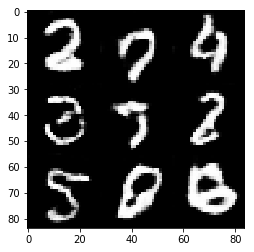

Epoch 2/2:  Discriminator Loss: 0.9245 Generator Loss: 0.6735
Epoch 2/2:  Discriminator Loss: 0.2518 Generator Loss: 1.8598
Epoch 2/2:  Discriminator Loss: 0.2574 Generator Loss: 1.8646
Epoch 2/2:  Discriminator Loss: 0.3999 Generator Loss: 1.3914
Epoch 2/2:  Discriminator Loss: 0.6818 Generator Loss: 1.1529
Epoch 2/2:  Discriminator Loss: 0.7434 Generator Loss: 1.1481
Epoch 2/2:  Discriminator Loss: 0.5698 Generator Loss: 1.1106
Epoch 2/2:  Discriminator Loss: 1.0673 Generator Loss: 0.5920
Epoch 2/2:  Discriminator Loss: 0.5782 Generator Loss: 1.1495
Epoch 2/2:  Discriminator Loss: 0.9073 Generator Loss: 0.7858


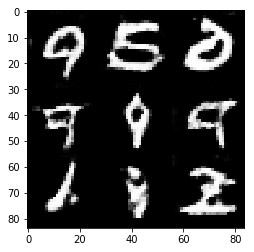

Epoch 2/2:  Discriminator Loss: 0.7959 Generator Loss: 0.9152
Epoch 2/2:  Discriminator Loss: 2.2242 Generator Loss: 0.1903
Epoch 2/2:  Discriminator Loss: 0.5215 Generator Loss: 3.4077
Epoch 2/2:  Discriminator Loss: 0.5138 Generator Loss: 1.5227
Epoch 2/2:  Discriminator Loss: 0.5470 Generator Loss: 1.2879
Epoch 2/2:  Discriminator Loss: 0.2229 Generator Loss: 2.1483
Epoch 2/2:  Discriminator Loss: 0.2071 Generator Loss: 2.0977
Epoch 2/2:  Discriminator Loss: 0.1108 Generator Loss: 3.0164
Epoch 2/2:  Discriminator Loss: 0.4393 Generator Loss: 1.4549
Epoch 2/2:  Discriminator Loss: 0.3891 Generator Loss: 1.4632


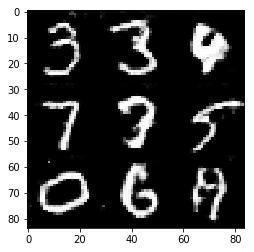

Epoch 2/2:  Discriminator Loss: 0.3415 Generator Loss: 1.5611
Epoch 2/2:  Discriminator Loss: 0.2280 Generator Loss: 1.8602
Epoch 2/2:  Discriminator Loss: 0.2135 Generator Loss: 2.2496
Epoch 2/2:  Discriminator Loss: 0.3368 Generator Loss: 1.6030
Epoch 2/2:  Discriminator Loss: 1.2487 Generator Loss: 0.8236
Epoch 2/2:  Discriminator Loss: 1.3659 Generator Loss: 0.5074
Epoch 2/2:  Discriminator Loss: 1.3729 Generator Loss: 0.4680
Epoch 2/2:  Discriminator Loss: 0.4919 Generator Loss: 1.3622
Epoch 2/2:  Discriminator Loss: 0.7309 Generator Loss: 1.1799
Epoch 2/2:  Discriminator Loss: 0.3369 Generator Loss: 1.9904


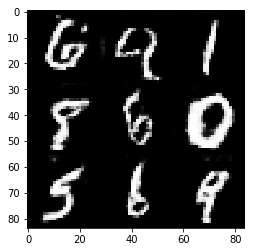

Epoch 2/2:  Discriminator Loss: 0.7420 Generator Loss: 0.9219
Epoch 2/2:  Discriminator Loss: 0.6430 Generator Loss: 1.0438
Epoch 2/2:  Discriminator Loss: 0.6177 Generator Loss: 1.1463
Epoch 2/2:  Discriminator Loss: 1.0124 Generator Loss: 0.7279
Epoch 2/2:  Discriminator Loss: 0.5147 Generator Loss: 1.2667
Epoch 2/2:  Discriminator Loss: 2.0476 Generator Loss: 6.1029
Epoch 2/2:  Discriminator Loss: 0.6800 Generator Loss: 1.1222
Epoch 2/2:  Discriminator Loss: 0.2785 Generator Loss: 2.2515
Epoch 2/2:  Discriminator Loss: 0.5909 Generator Loss: 1.1964
Epoch 2/2:  Discriminator Loss: 0.3898 Generator Loss: 1.4316


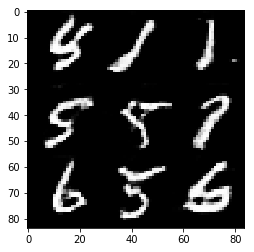

Epoch 2/2:  Discriminator Loss: 0.3002 Generator Loss: 1.8395
Epoch 2/2:  Discriminator Loss: 0.2339 Generator Loss: 2.7503
Epoch 2/2:  Discriminator Loss: 0.3833 Generator Loss: 2.7843
Epoch 2/2:  Discriminator Loss: 0.2198 Generator Loss: 3.5417
Epoch 2/2:  Discriminator Loss: 0.3207 Generator Loss: 1.6349
Epoch 2/2:  Discriminator Loss: 0.5772 Generator Loss: 2.4686
Epoch 2/2:  Discriminator Loss: 0.8574 Generator Loss: 0.8164
Epoch 2/2:  Discriminator Loss: 3.4037 Generator Loss: 0.1438
Epoch 2/2:  Discriminator Loss: 2.1696 Generator Loss: 0.2277
Epoch 2/2:  Discriminator Loss: 0.5997 Generator Loss: 1.2496


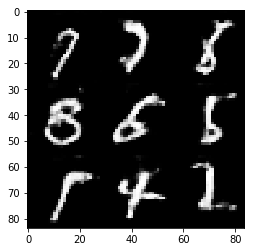

Epoch 2/2:  Discriminator Loss: 0.6456 Generator Loss: 2.3295
Epoch 2/2:  Discriminator Loss: 0.6846 Generator Loss: 0.9379
Epoch 2/2:  Discriminator Loss: 0.5614 Generator Loss: 1.0459
Epoch 2/2:  Discriminator Loss: 0.4022 Generator Loss: 1.2923
Epoch 2/2:  Discriminator Loss: 0.5075 Generator Loss: 1.5357
Epoch 2/2:  Discriminator Loss: 0.3896 Generator Loss: 1.5143
Epoch 2/2:  Discriminator Loss: 0.6326 Generator Loss: 1.0853
Epoch 2/2:  Discriminator Loss: 0.2518 Generator Loss: 2.1185
Epoch 2/2:  Discriminator Loss: 0.6795 Generator Loss: 0.9107
Epoch 2/2:  Discriminator Loss: 0.5760 Generator Loss: 1.2475


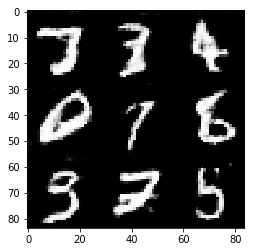

Epoch 2/2:  Discriminator Loss: 0.1495 Generator Loss: 2.3451
Epoch 2/2:  Discriminator Loss: 0.5687 Generator Loss: 1.0712
Epoch 2/2:  Discriminator Loss: 0.2186 Generator Loss: 2.0396
Epoch 2/2:  Discriminator Loss: 0.2255 Generator Loss: 2.0377
Epoch 2/2:  Discriminator Loss: 1.8346 Generator Loss: 0.3544


In [53]:
batch_size = 32
z_dim = 32
learning_rate = 0.0005
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1:  Discriminator Loss: 5.2685 Generator Loss: 0.0483
Epoch 1/1:  Discriminator Loss: 4.2601 Generator Loss: 0.0171
Epoch 1/1:  Discriminator Loss: 2.8618 Generator Loss: 0.0748
Epoch 1/1:  Discriminator Loss: 2.0479 Generator Loss: 0.1921
Epoch 1/1:  Discriminator Loss: 1.5948 Generator Loss: 0.3241
Epoch 1/1:  Discriminator Loss: 2.1209 Generator Loss: 0.1935
Epoch 1/1:  Discriminator Loss: 1.5491 Generator Loss: 0.3252
Epoch 1/1:  Discriminator Loss: 0.9133 Generator Loss: 0.6851
Epoch 1/1:  Discriminator Loss: 1.9239 Generator Loss: 0.2239
Epoch 1/1:  Discriminator Loss: 0.8644 Generator Loss: 0.7376


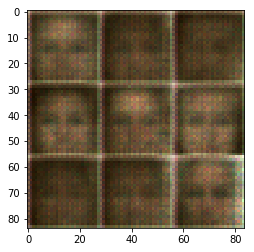

Epoch 1/1:  Discriminator Loss: 1.1309 Generator Loss: 0.7736
Epoch 1/1:  Discriminator Loss: 1.5878 Generator Loss: 0.2945
Epoch 1/1:  Discriminator Loss: 2.1833 Generator Loss: 0.1354
Epoch 1/1:  Discriminator Loss: 1.1509 Generator Loss: 0.5055
Epoch 1/1:  Discriminator Loss: 1.1549 Generator Loss: 0.4737
Epoch 1/1:  Discriminator Loss: 1.2808 Generator Loss: 0.4566
Epoch 1/1:  Discriminator Loss: 1.3575 Generator Loss: 0.3781
Epoch 1/1:  Discriminator Loss: 1.2877 Generator Loss: 0.4135
Epoch 1/1:  Discriminator Loss: 1.1190 Generator Loss: 1.6729
Epoch 1/1:  Discriminator Loss: 1.5068 Generator Loss: 0.6406


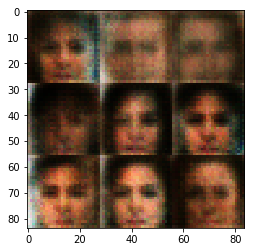

Epoch 1/1:  Discriminator Loss: 1.0448 Generator Loss: 2.8483
Epoch 1/1:  Discriminator Loss: 0.8204 Generator Loss: 3.1943
Epoch 1/1:  Discriminator Loss: 0.3950 Generator Loss: 1.4006
Epoch 1/1:  Discriminator Loss: 1.1823 Generator Loss: 0.4896
Epoch 1/1:  Discriminator Loss: 1.3233 Generator Loss: 0.3688
Epoch 1/1:  Discriminator Loss: 0.3477 Generator Loss: 1.5980
Epoch 1/1:  Discriminator Loss: 1.1400 Generator Loss: 0.4501
Epoch 1/1:  Discriminator Loss: 0.5064 Generator Loss: 4.8853
Epoch 1/1:  Discriminator Loss: 0.1436 Generator Loss: 4.5402
Epoch 1/1:  Discriminator Loss: 0.1366 Generator Loss: 2.9949


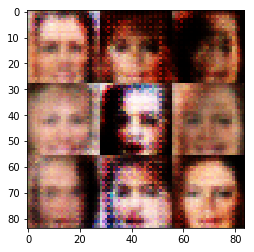

Epoch 1/1:  Discriminator Loss: 0.0661 Generator Loss: 4.3087
Epoch 1/1:  Discriminator Loss: 0.8411 Generator Loss: 1.0001
Epoch 1/1:  Discriminator Loss: 0.3818 Generator Loss: 1.4692
Epoch 1/1:  Discriminator Loss: 0.2012 Generator Loss: 2.0683
Epoch 1/1:  Discriminator Loss: 0.4544 Generator Loss: 1.1876
Epoch 1/1:  Discriminator Loss: 0.1456 Generator Loss: 2.5002
Epoch 1/1:  Discriminator Loss: 0.1862 Generator Loss: 5.0178
Epoch 1/1:  Discriminator Loss: 2.0282 Generator Loss: 4.5797
Epoch 1/1:  Discriminator Loss: 1.2470 Generator Loss: 0.6591
Epoch 1/1:  Discriminator Loss: 0.0888 Generator Loss: 3.5593


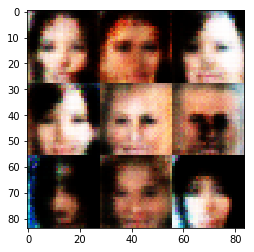

Epoch 1/1:  Discriminator Loss: 3.8474 Generator Loss: 4.4836
Epoch 1/1:  Discriminator Loss: 0.4242 Generator Loss: 1.3646
Epoch 1/1:  Discriminator Loss: 0.0730 Generator Loss: 3.5274
Epoch 1/1:  Discriminator Loss: 0.5566 Generator Loss: 1.0313
Epoch 1/1:  Discriminator Loss: 2.6374 Generator Loss: 3.4064
Epoch 1/1:  Discriminator Loss: 0.9384 Generator Loss: 1.0920
Epoch 1/1:  Discriminator Loss: 1.0028 Generator Loss: 0.5811
Epoch 1/1:  Discriminator Loss: 0.2090 Generator Loss: 2.1040
Epoch 1/1:  Discriminator Loss: 0.5099 Generator Loss: 3.0159
Epoch 1/1:  Discriminator Loss: 0.7814 Generator Loss: 0.7385


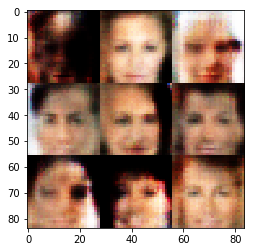

Epoch 1/1:  Discriminator Loss: 0.0958 Generator Loss: 3.3320
Epoch 1/1:  Discriminator Loss: 0.2495 Generator Loss: 1.7901
Epoch 1/1:  Discriminator Loss: 1.6347 Generator Loss: 1.6633
Epoch 1/1:  Discriminator Loss: 1.0912 Generator Loss: 1.9054
Epoch 1/1:  Discriminator Loss: 0.8206 Generator Loss: 0.6981
Epoch 1/1:  Discriminator Loss: 0.6991 Generator Loss: 0.9570
Epoch 1/1:  Discriminator Loss: 0.2117 Generator Loss: 3.8437
Epoch 1/1:  Discriminator Loss: 0.1113 Generator Loss: 2.6647
Epoch 1/1:  Discriminator Loss: 1.1886 Generator Loss: 5.3899
Epoch 1/1:  Discriminator Loss: 0.0262 Generator Loss: 5.0073


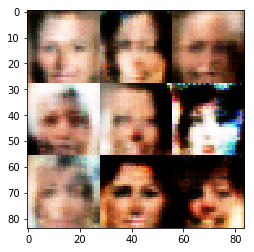

Epoch 1/1:  Discriminator Loss: 1.5200 Generator Loss: 0.3466
Epoch 1/1:  Discriminator Loss: 1.6364 Generator Loss: 0.3045
Epoch 1/1:  Discriminator Loss: 1.0431 Generator Loss: 0.9072
Epoch 1/1:  Discriminator Loss: 0.3143 Generator Loss: 1.4810
Epoch 1/1:  Discriminator Loss: 1.1881 Generator Loss: 2.2649
Epoch 1/1:  Discriminator Loss: 0.1180 Generator Loss: 2.9859
Epoch 1/1:  Discriminator Loss: 0.1254 Generator Loss: 2.6535
Epoch 1/1:  Discriminator Loss: 1.2343 Generator Loss: 3.6696
Epoch 1/1:  Discriminator Loss: 1.6711 Generator Loss: 0.2727
Epoch 1/1:  Discriminator Loss: 1.6811 Generator Loss: 4.4901


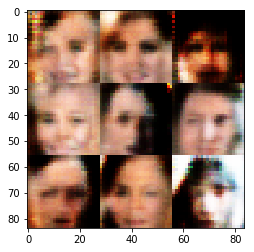

Epoch 1/1:  Discriminator Loss: 0.2948 Generator Loss: 1.6004
Epoch 1/1:  Discriminator Loss: 0.4645 Generator Loss: 1.2646
Epoch 1/1:  Discriminator Loss: 0.1823 Generator Loss: 4.2075
Epoch 1/1:  Discriminator Loss: 0.8343 Generator Loss: 1.7920
Epoch 1/1:  Discriminator Loss: 1.1706 Generator Loss: 0.4448
Epoch 1/1:  Discriminator Loss: 0.7585 Generator Loss: 0.7966
Epoch 1/1:  Discriminator Loss: 0.1466 Generator Loss: 3.2361
Epoch 1/1:  Discriminator Loss: 0.4117 Generator Loss: 4.2988
Epoch 1/1:  Discriminator Loss: 0.1538 Generator Loss: 3.3353
Epoch 1/1:  Discriminator Loss: 0.3234 Generator Loss: 2.5558


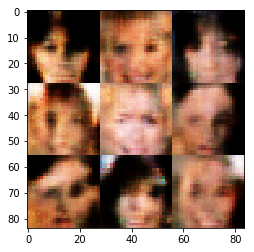

Epoch 1/1:  Discriminator Loss: 0.9282 Generator Loss: 0.6654
Epoch 1/1:  Discriminator Loss: 1.0940 Generator Loss: 0.5008
Epoch 1/1:  Discriminator Loss: 0.5929 Generator Loss: 0.9830
Epoch 1/1:  Discriminator Loss: 0.3416 Generator Loss: 2.7105
Epoch 1/1:  Discriminator Loss: 0.5113 Generator Loss: 2.1765
Epoch 1/1:  Discriminator Loss: 0.3629 Generator Loss: 6.3897
Epoch 1/1:  Discriminator Loss: 0.0451 Generator Loss: 4.7682
Epoch 1/1:  Discriminator Loss: 0.1179 Generator Loss: 4.1502
Epoch 1/1:  Discriminator Loss: 0.0601 Generator Loss: 4.3881
Epoch 1/1:  Discriminator Loss: 0.0772 Generator Loss: 6.2473


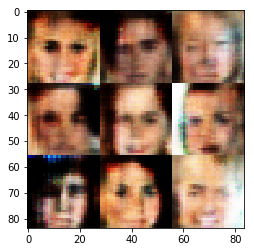

Epoch 1/1:  Discriminator Loss: 0.8379 Generator Loss: 2.0013
Epoch 1/1:  Discriminator Loss: 0.2459 Generator Loss: 1.8328
Epoch 1/1:  Discriminator Loss: 0.1595 Generator Loss: 2.5520
Epoch 1/1:  Discriminator Loss: 0.0964 Generator Loss: 2.9986
Epoch 1/1:  Discriminator Loss: 1.6157 Generator Loss: 1.9280
Epoch 1/1:  Discriminator Loss: 1.0411 Generator Loss: 2.3211
Epoch 1/1:  Discriminator Loss: 0.9674 Generator Loss: 1.3682
Epoch 1/1:  Discriminator Loss: 0.9984 Generator Loss: 0.6726
Epoch 1/1:  Discriminator Loss: 0.8978 Generator Loss: 0.8388
Epoch 1/1:  Discriminator Loss: 0.9859 Generator Loss: 0.5823


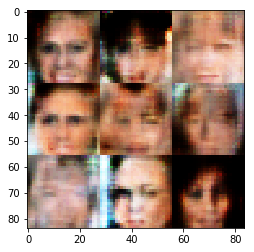

Epoch 1/1:  Discriminator Loss: 1.3550 Generator Loss: 0.5007
Epoch 1/1:  Discriminator Loss: 1.0589 Generator Loss: 0.5103
Epoch 1/1:  Discriminator Loss: 0.2335 Generator Loss: 2.0667
Epoch 1/1:  Discriminator Loss: 0.5532 Generator Loss: 1.0388
Epoch 1/1:  Discriminator Loss: 0.1340 Generator Loss: 3.3524
Epoch 1/1:  Discriminator Loss: 2.0368 Generator Loss: 4.1051
Epoch 1/1:  Discriminator Loss: 0.2580 Generator Loss: 2.2197
Epoch 1/1:  Discriminator Loss: 0.1870 Generator Loss: 2.2571
Epoch 1/1:  Discriminator Loss: 0.8761 Generator Loss: 0.7240
Epoch 1/1:  Discriminator Loss: 0.1700 Generator Loss: 2.0885


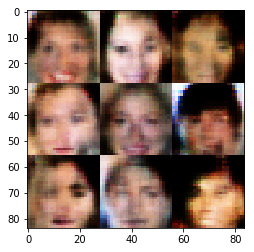

Epoch 1/1:  Discriminator Loss: 0.7982 Generator Loss: 0.8912
Epoch 1/1:  Discriminator Loss: 0.1472 Generator Loss: 2.3422
Epoch 1/1:  Discriminator Loss: 0.4207 Generator Loss: 2.2080
Epoch 1/1:  Discriminator Loss: 0.1882 Generator Loss: 2.7304
Epoch 1/1:  Discriminator Loss: 0.0343 Generator Loss: 4.0709
Epoch 1/1:  Discriminator Loss: 0.9394 Generator Loss: 0.6749
Epoch 1/1:  Discriminator Loss: 0.0921 Generator Loss: 3.5056
Epoch 1/1:  Discriminator Loss: 1.6995 Generator Loss: 4.5619
Epoch 1/1:  Discriminator Loss: 0.1111 Generator Loss: 2.6127
Epoch 1/1:  Discriminator Loss: 0.5918 Generator Loss: 2.1621


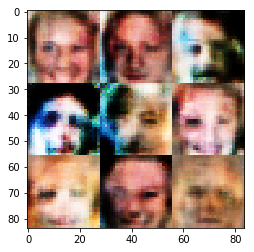

Epoch 1/1:  Discriminator Loss: 0.0854 Generator Loss: 2.9759
Epoch 1/1:  Discriminator Loss: 0.0515 Generator Loss: 4.2076
Epoch 1/1:  Discriminator Loss: 0.0390 Generator Loss: 4.0688
Epoch 1/1:  Discriminator Loss: 0.0835 Generator Loss: 4.9733
Epoch 1/1:  Discriminator Loss: 4.2459 Generator Loss: 5.6641
Epoch 1/1:  Discriminator Loss: 1.3859 Generator Loss: 0.4397
Epoch 1/1:  Discriminator Loss: 0.3015 Generator Loss: 2.0203
Epoch 1/1:  Discriminator Loss: 0.4349 Generator Loss: 5.2240
Epoch 1/1:  Discriminator Loss: 1.3328 Generator Loss: 1.5925
Epoch 1/1:  Discriminator Loss: 0.4169 Generator Loss: 2.5001


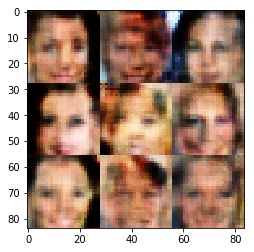

Epoch 1/1:  Discriminator Loss: 1.2195 Generator Loss: 1.8932
Epoch 1/1:  Discriminator Loss: 0.1162 Generator Loss: 2.7341
Epoch 1/1:  Discriminator Loss: 1.2122 Generator Loss: 0.8245
Epoch 1/1:  Discriminator Loss: 1.2338 Generator Loss: 0.5347
Epoch 1/1:  Discriminator Loss: 1.3297 Generator Loss: 0.4408
Epoch 1/1:  Discriminator Loss: 0.8204 Generator Loss: 0.6986
Epoch 1/1:  Discriminator Loss: 1.9542 Generator Loss: 0.1853
Epoch 1/1:  Discriminator Loss: 0.2860 Generator Loss: 1.6635
Epoch 1/1:  Discriminator Loss: 0.1348 Generator Loss: 3.6360
Epoch 1/1:  Discriminator Loss: 1.0959 Generator Loss: 0.8087


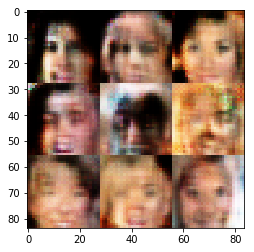

Epoch 1/1:  Discriminator Loss: 0.9685 Generator Loss: 1.0242
Epoch 1/1:  Discriminator Loss: 1.1611 Generator Loss: 1.2136
Epoch 1/1:  Discriminator Loss: 0.9693 Generator Loss: 0.9465
Epoch 1/1:  Discriminator Loss: 0.9811 Generator Loss: 0.7135
Epoch 1/1:  Discriminator Loss: 0.2159 Generator Loss: 2.3347
Epoch 1/1:  Discriminator Loss: 0.7131 Generator Loss: 1.5347
Epoch 1/1:  Discriminator Loss: 0.3742 Generator Loss: 4.2360
Epoch 1/1:  Discriminator Loss: 0.8767 Generator Loss: 2.8422
Epoch 1/1:  Discriminator Loss: 0.1864 Generator Loss: 3.6986
Epoch 1/1:  Discriminator Loss: 0.0625 Generator Loss: 3.8223


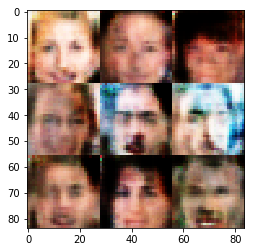

Epoch 1/1:  Discriminator Loss: 0.0595 Generator Loss: 3.3080
Epoch 1/1:  Discriminator Loss: 2.3871 Generator Loss: 0.2194
Epoch 1/1:  Discriminator Loss: 0.7505 Generator Loss: 0.9795
Epoch 1/1:  Discriminator Loss: 0.8439 Generator Loss: 0.8274
Epoch 1/1:  Discriminator Loss: 0.7717 Generator Loss: 2.8392
Epoch 1/1:  Discriminator Loss: 0.0370 Generator Loss: 4.1751
Epoch 1/1:  Discriminator Loss: 1.1118 Generator Loss: 0.9377
Epoch 1/1:  Discriminator Loss: 0.8567 Generator Loss: 1.4642
Epoch 1/1:  Discriminator Loss: 0.8839 Generator Loss: 1.2177
Epoch 1/1:  Discriminator Loss: 0.1282 Generator Loss: 4.2782


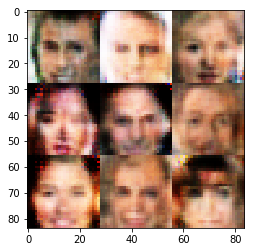

Epoch 1/1:  Discriminator Loss: 2.3054 Generator Loss: 5.0626
Epoch 1/1:  Discriminator Loss: 0.1363 Generator Loss: 3.5961
Epoch 1/1:  Discriminator Loss: 0.0738 Generator Loss: 4.1998
Epoch 1/1:  Discriminator Loss: 0.0317 Generator Loss: 4.1584
Epoch 1/1:  Discriminator Loss: 1.1345 Generator Loss: 0.8534
Epoch 1/1:  Discriminator Loss: 0.7065 Generator Loss: 0.9593
Epoch 1/1:  Discriminator Loss: 1.2548 Generator Loss: 1.2229
Epoch 1/1:  Discriminator Loss: 0.6960 Generator Loss: 1.9430
Epoch 1/1:  Discriminator Loss: 0.1276 Generator Loss: 2.7250
Epoch 1/1:  Discriminator Loss: 1.2519 Generator Loss: 0.4277


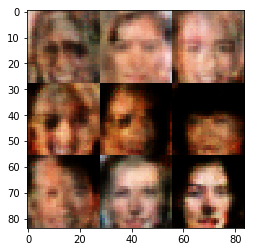

Epoch 1/1:  Discriminator Loss: 0.3592 Generator Loss: 3.5401
Epoch 1/1:  Discriminator Loss: 2.1537 Generator Loss: 0.1463
Epoch 1/1:  Discriminator Loss: 0.6366 Generator Loss: 3.2760
Epoch 1/1:  Discriminator Loss: 0.4659 Generator Loss: 1.5191
Epoch 1/1:  Discriminator Loss: 0.4472 Generator Loss: 1.2088
Epoch 1/1:  Discriminator Loss: 0.0757 Generator Loss: 3.4948
Epoch 1/1:  Discriminator Loss: 0.0724 Generator Loss: 2.9670
Epoch 1/1:  Discriminator Loss: 0.0599 Generator Loss: 4.4954
Epoch 1/1:  Discriminator Loss: 0.0700 Generator Loss: 3.2341
Epoch 1/1:  Discriminator Loss: 0.0172 Generator Loss: 5.7039


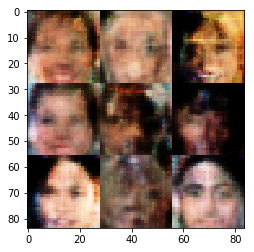

Epoch 1/1:  Discriminator Loss: 0.0228 Generator Loss: 5.3079
Epoch 1/1:  Discriminator Loss: 0.1048 Generator Loss: 5.7509
Epoch 1/1:  Discriminator Loss: 0.9092 Generator Loss: 0.8445
Epoch 1/1:  Discriminator Loss: 0.7502 Generator Loss: 2.0856
Epoch 1/1:  Discriminator Loss: 0.5689 Generator Loss: 2.0759
Epoch 1/1:  Discriminator Loss: 0.9114 Generator Loss: 0.6245
Epoch 1/1:  Discriminator Loss: 1.0908 Generator Loss: 3.3580
Epoch 1/1:  Discriminator Loss: 0.0675 Generator Loss: 4.1550
Epoch 1/1:  Discriminator Loss: 0.4411 Generator Loss: 3.3526
Epoch 1/1:  Discriminator Loss: 0.0619 Generator Loss: 3.4303


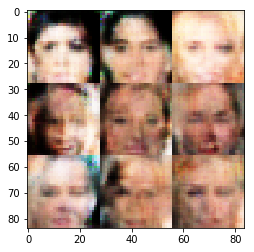

Epoch 1/1:  Discriminator Loss: 0.0884 Generator Loss: 3.1803
Epoch 1/1:  Discriminator Loss: 0.0862 Generator Loss: 3.0375
Epoch 1/1:  Discriminator Loss: 0.0279 Generator Loss: 5.5518
Epoch 1/1:  Discriminator Loss: 0.0349 Generator Loss: 4.0183
Epoch 1/1:  Discriminator Loss: 1.0995 Generator Loss: 0.6043
Epoch 1/1:  Discriminator Loss: 1.1664 Generator Loss: 0.5333
Epoch 1/1:  Discriminator Loss: 0.4996 Generator Loss: 1.5494
Epoch 1/1:  Discriminator Loss: 1.8482 Generator Loss: 2.8317
Epoch 1/1:  Discriminator Loss: 0.6358 Generator Loss: 2.7663
Epoch 1/1:  Discriminator Loss: 0.6253 Generator Loss: 3.1724


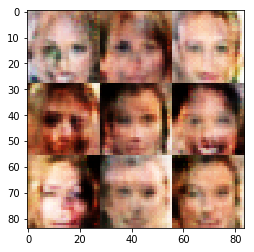

Epoch 1/1:  Discriminator Loss: 0.0646 Generator Loss: 3.8752
Epoch 1/1:  Discriminator Loss: 1.2900 Generator Loss: 3.8038
Epoch 1/1:  Discriminator Loss: 0.3759 Generator Loss: 1.9428
Epoch 1/1:  Discriminator Loss: 0.1154 Generator Loss: 2.6264
Epoch 1/1:  Discriminator Loss: 3.4381 Generator Loss: 4.3248
Epoch 1/1:  Discriminator Loss: 0.2707 Generator Loss: 1.7896
Epoch 1/1:  Discriminator Loss: 0.0851 Generator Loss: 3.6818
Epoch 1/1:  Discriminator Loss: 0.0629 Generator Loss: 3.4543
Epoch 1/1:  Discriminator Loss: 1.1298 Generator Loss: 0.5079
Epoch 1/1:  Discriminator Loss: 0.0504 Generator Loss: 3.8158


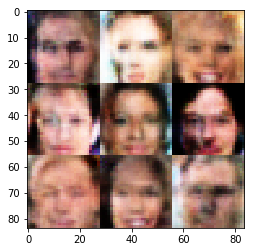

Epoch 1/1:  Discriminator Loss: 1.9032 Generator Loss: 1.7904
Epoch 1/1:  Discriminator Loss: 1.1821 Generator Loss: 1.4507
Epoch 1/1:  Discriminator Loss: 0.9955 Generator Loss: 1.2136
Epoch 1/1:  Discriminator Loss: 1.1405 Generator Loss: 0.5751
Epoch 1/1:  Discriminator Loss: 1.1098 Generator Loss: 0.5482
Epoch 1/1:  Discriminator Loss: 1.2085 Generator Loss: 1.8784
Epoch 1/1:  Discriminator Loss: 0.8408 Generator Loss: 1.7355
Epoch 1/1:  Discriminator Loss: 0.2123 Generator Loss: 1.9176
Epoch 1/1:  Discriminator Loss: 0.9643 Generator Loss: 1.7851
Epoch 1/1:  Discriminator Loss: 0.3278 Generator Loss: 1.6154


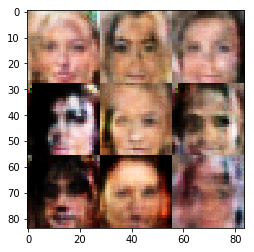

Epoch 1/1:  Discriminator Loss: 0.7050 Generator Loss: 2.0133
Epoch 1/1:  Discriminator Loss: 0.1234 Generator Loss: 2.7142
Epoch 1/1:  Discriminator Loss: 0.0348 Generator Loss: 4.5275
Epoch 1/1:  Discriminator Loss: 1.1596 Generator Loss: 0.5540
Epoch 1/1:  Discriminator Loss: 0.4628 Generator Loss: 2.9396
Epoch 1/1:  Discriminator Loss: 0.1523 Generator Loss: 2.3550
Epoch 1/1:  Discriminator Loss: 0.1733 Generator Loss: 2.1889
Epoch 1/1:  Discriminator Loss: 0.0441 Generator Loss: 4.0867
Epoch 1/1:  Discriminator Loss: 0.4604 Generator Loss: 4.9369
Epoch 1/1:  Discriminator Loss: 0.9508 Generator Loss: 0.6573


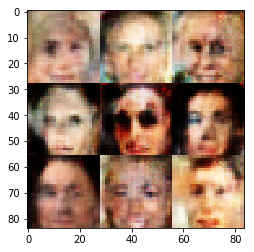

Epoch 1/1:  Discriminator Loss: 0.1367 Generator Loss: 3.0008
Epoch 1/1:  Discriminator Loss: 0.0588 Generator Loss: 3.4549
Epoch 1/1:  Discriminator Loss: 0.0250 Generator Loss: 5.1374
Epoch 1/1:  Discriminator Loss: 0.0446 Generator Loss: 4.8612
Epoch 1/1:  Discriminator Loss: 0.0259 Generator Loss: 5.1290
Epoch 1/1:  Discriminator Loss: 0.0193 Generator Loss: 5.7048
Epoch 1/1:  Discriminator Loss: 0.5473 Generator Loss: 2.3033
Epoch 1/1:  Discriminator Loss: 0.3462 Generator Loss: 1.4075
Epoch 1/1:  Discriminator Loss: 0.0471 Generator Loss: 4.9594
Epoch 1/1:  Discriminator Loss: 5.7443 Generator Loss: 7.0992


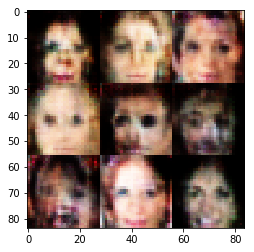

Epoch 1/1:  Discriminator Loss: 1.0328 Generator Loss: 0.6406
Epoch 1/1:  Discriminator Loss: 0.7439 Generator Loss: 0.8484
Epoch 1/1:  Discriminator Loss: 2.1707 Generator Loss: 4.3605
Epoch 1/1:  Discriminator Loss: 0.2684 Generator Loss: 1.7556
Epoch 1/1:  Discriminator Loss: 0.0862 Generator Loss: 5.4745
Epoch 1/1:  Discriminator Loss: 0.7341 Generator Loss: 4.4552
Epoch 1/1:  Discriminator Loss: 0.7243 Generator Loss: 1.3440
Epoch 1/1:  Discriminator Loss: 0.5168 Generator Loss: 2.6535
Epoch 1/1:  Discriminator Loss: 0.2205 Generator Loss: 2.2676
Epoch 1/1:  Discriminator Loss: 1.2334 Generator Loss: 2.1985


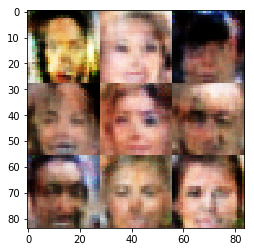

Epoch 1/1:  Discriminator Loss: 0.8113 Generator Loss: 0.7214
Epoch 1/1:  Discriminator Loss: 0.4498 Generator Loss: 1.3363
Epoch 1/1:  Discriminator Loss: 2.2787 Generator Loss: 0.1362
Epoch 1/1:  Discriminator Loss: 0.8983 Generator Loss: 3.9899
Epoch 1/1:  Discriminator Loss: 0.2006 Generator Loss: 2.0651
Epoch 1/1:  Discriminator Loss: 0.8724 Generator Loss: 1.4200
Epoch 1/1:  Discriminator Loss: 0.0502 Generator Loss: 3.8498
Epoch 1/1:  Discriminator Loss: 0.0878 Generator Loss: 2.6631
Epoch 1/1:  Discriminator Loss: 1.0856 Generator Loss: 0.5137
Epoch 1/1:  Discriminator Loss: 0.1264 Generator Loss: 4.1467


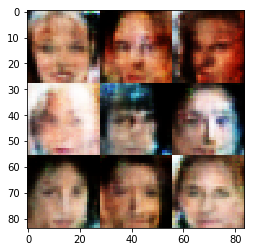

Epoch 1/1:  Discriminator Loss: 2.4841 Generator Loss: 2.9078
Epoch 1/1:  Discriminator Loss: 0.9153 Generator Loss: 1.6241
Epoch 1/1:  Discriminator Loss: 0.5055 Generator Loss: 2.4620
Epoch 1/1:  Discriminator Loss: 0.2756 Generator Loss: 1.6672
Epoch 1/1:  Discriminator Loss: 0.2581 Generator Loss: 3.6570
Epoch 1/1:  Discriminator Loss: 0.3274 Generator Loss: 1.7811
Epoch 1/1:  Discriminator Loss: 0.1344 Generator Loss: 2.7734
Epoch 1/1:  Discriminator Loss: 0.3889 Generator Loss: 1.2738
Epoch 1/1:  Discriminator Loss: 0.3047 Generator Loss: 1.6633
Epoch 1/1:  Discriminator Loss: 0.0703 Generator Loss: 3.6443


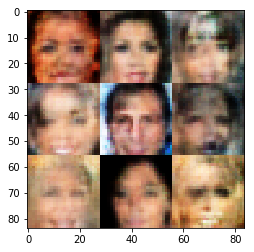

Epoch 1/1:  Discriminator Loss: 1.1705 Generator Loss: 1.1786
Epoch 1/1:  Discriminator Loss: 1.1909 Generator Loss: 0.7138
Epoch 1/1:  Discriminator Loss: 1.1671 Generator Loss: 0.4971
Epoch 1/1:  Discriminator Loss: 0.2084 Generator Loss: 2.1974
Epoch 1/1:  Discriminator Loss: 1.4849 Generator Loss: 0.4259
Epoch 1/1:  Discriminator Loss: 0.6451 Generator Loss: 3.0097
Epoch 1/1:  Discriminator Loss: 0.2382 Generator Loss: 2.0834
Epoch 1/1:  Discriminator Loss: 0.5539 Generator Loss: 1.0739
Epoch 1/1:  Discriminator Loss: 2.4364 Generator Loss: 0.1157
Epoch 1/1:  Discriminator Loss: 0.5546 Generator Loss: 2.0745


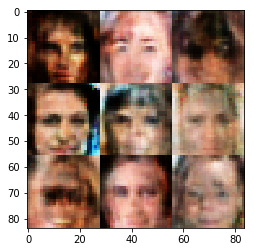

Epoch 1/1:  Discriminator Loss: 0.2394 Generator Loss: 1.7648
Epoch 1/1:  Discriminator Loss: 1.1792 Generator Loss: 0.7198
Epoch 1/1:  Discriminator Loss: 0.4598 Generator Loss: 1.7925
Epoch 1/1:  Discriminator Loss: 0.0982 Generator Loss: 3.8095
Epoch 1/1:  Discriminator Loss: 0.0669 Generator Loss: 4.5728
Epoch 1/1:  Discriminator Loss: 0.6267 Generator Loss: 0.9954
Epoch 1/1:  Discriminator Loss: 0.1134 Generator Loss: 3.1841
Epoch 1/1:  Discriminator Loss: 1.8340 Generator Loss: 0.3167
Epoch 1/1:  Discriminator Loss: 0.4082 Generator Loss: 1.3730
Epoch 1/1:  Discriminator Loss: 0.0516 Generator Loss: 3.6305


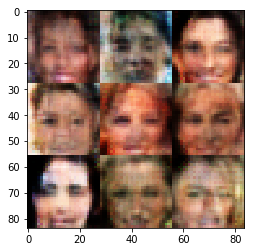

Epoch 1/1:  Discriminator Loss: 1.0326 Generator Loss: 2.3786
Epoch 1/1:  Discriminator Loss: 0.4349 Generator Loss: 1.5954
Epoch 1/1:  Discriminator Loss: 1.5455 Generator Loss: 3.2587
Epoch 1/1:  Discriminator Loss: 1.1950 Generator Loss: 2.1014
Epoch 1/1:  Discriminator Loss: 0.2007 Generator Loss: 2.4571
Epoch 1/1:  Discriminator Loss: 0.0507 Generator Loss: 5.5679
Epoch 1/1:  Discriminator Loss: 0.9309 Generator Loss: 4.4653
Epoch 1/1:  Discriminator Loss: 1.1751 Generator Loss: 0.5257
Epoch 1/1:  Discriminator Loss: 0.3899 Generator Loss: 1.3293
Epoch 1/1:  Discriminator Loss: 2.8525 Generator Loss: 4.2326


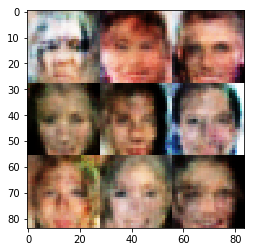

Epoch 1/1:  Discriminator Loss: 0.1009 Generator Loss: 3.6511
Epoch 1/1:  Discriminator Loss: 0.0521 Generator Loss: 5.0971
Epoch 1/1:  Discriminator Loss: 0.2753 Generator Loss: 5.2260
Epoch 1/1:  Discriminator Loss: 0.0663 Generator Loss: 3.2634
Epoch 1/1:  Discriminator Loss: 0.0472 Generator Loss: 3.8041
Epoch 1/1:  Discriminator Loss: 0.0275 Generator Loss: 4.8235
Epoch 1/1:  Discriminator Loss: 0.1463 Generator Loss: 2.1814
Epoch 1/1:  Discriminator Loss: 0.0337 Generator Loss: 4.8023
Epoch 1/1:  Discriminator Loss: 0.0211 Generator Loss: 5.5427
Epoch 1/1:  Discriminator Loss: 0.0191 Generator Loss: 4.9205


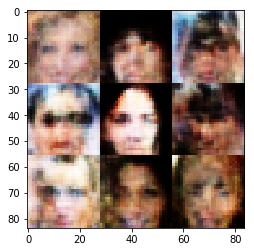

Epoch 1/1:  Discriminator Loss: 0.1201 Generator Loss: 2.4404
Epoch 1/1:  Discriminator Loss: 0.4916 Generator Loss: 2.2482
Epoch 1/1:  Discriminator Loss: 0.5866 Generator Loss: 3.2080
Epoch 1/1:  Discriminator Loss: 0.0984 Generator Loss: 3.2721
Epoch 1/1:  Discriminator Loss: 1.4090 Generator Loss: 4.3567
Epoch 1/1:  Discriminator Loss: 0.8907 Generator Loss: 0.7259
Epoch 1/1:  Discriminator Loss: 0.1883 Generator Loss: 2.3539
Epoch 1/1:  Discriminator Loss: 1.5317 Generator Loss: 0.3699
Epoch 1/1:  Discriminator Loss: 0.3214 Generator Loss: 1.6347
Epoch 1/1:  Discriminator Loss: 0.0731 Generator Loss: 3.5874


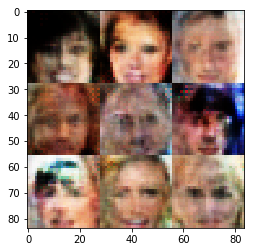

Epoch 1/1:  Discriminator Loss: 1.6295 Generator Loss: 1.6001
Epoch 1/1:  Discriminator Loss: 0.6991 Generator Loss: 1.1682
Epoch 1/1:  Discriminator Loss: 0.8732 Generator Loss: 0.8402
Epoch 1/1:  Discriminator Loss: 1.0724 Generator Loss: 0.7819
Epoch 1/1:  Discriminator Loss: 0.1250 Generator Loss: 2.4545
Epoch 1/1:  Discriminator Loss: 3.7274 Generator Loss: 4.8487
Epoch 1/1:  Discriminator Loss: 0.7524 Generator Loss: 2.1119
Epoch 1/1:  Discriminator Loss: 1.3496 Generator Loss: 0.4597
Epoch 1/1:  Discriminator Loss: 0.8228 Generator Loss: 0.7115
Epoch 1/1:  Discriminator Loss: 0.4596 Generator Loss: 1.1400


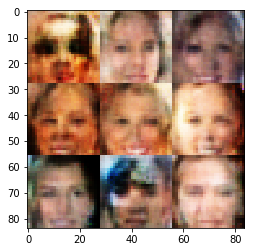

Epoch 1/1:  Discriminator Loss: 0.3248 Generator Loss: 1.5961
Epoch 1/1:  Discriminator Loss: 0.1349 Generator Loss: 4.0993
Epoch 1/1:  Discriminator Loss: 1.9295 Generator Loss: 0.2283
Epoch 1/1:  Discriminator Loss: 0.0636 Generator Loss: 4.4333
Epoch 1/1:  Discriminator Loss: 0.1210 Generator Loss: 5.4170
Epoch 1/1:  Discriminator Loss: 0.3699 Generator Loss: 1.3903
Epoch 1/1:  Discriminator Loss: 0.8550 Generator Loss: 1.8440
Epoch 1/1:  Discriminator Loss: 0.2094 Generator Loss: 2.0501
Epoch 1/1:  Discriminator Loss: 0.4550 Generator Loss: 1.4495
Epoch 1/1:  Discriminator Loss: 0.4666 Generator Loss: 1.1346


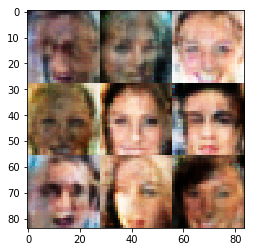

Epoch 1/1:  Discriminator Loss: 0.1838 Generator Loss: 5.4322
Epoch 1/1:  Discriminator Loss: 0.8244 Generator Loss: 1.0081
Epoch 1/1:  Discriminator Loss: 0.1311 Generator Loss: 2.6696
Epoch 1/1:  Discriminator Loss: 1.6291 Generator Loss: 0.5791
Epoch 1/1:  Discriminator Loss: 0.0340 Generator Loss: 4.7171
Epoch 1/1:  Discriminator Loss: 0.5755 Generator Loss: 1.0297
Epoch 1/1:  Discriminator Loss: 0.1090 Generator Loss: 3.9221
Epoch 1/1:  Discriminator Loss: 0.5025 Generator Loss: 1.1660
Epoch 1/1:  Discriminator Loss: 1.7715 Generator Loss: 0.2623
Epoch 1/1:  Discriminator Loss: 0.1265 Generator Loss: 2.7105


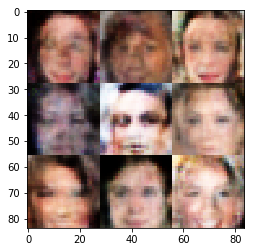

Epoch 1/1:  Discriminator Loss: 0.0804 Generator Loss: 4.1957
Epoch 1/1:  Discriminator Loss: 2.3587 Generator Loss: 0.1661
Epoch 1/1:  Discriminator Loss: 0.1137 Generator Loss: 4.3388
Epoch 1/1:  Discriminator Loss: 0.2990 Generator Loss: 1.6814
Epoch 1/1:  Discriminator Loss: 0.4813 Generator Loss: 3.9094
Epoch 1/1:  Discriminator Loss: 0.0796 Generator Loss: 3.8516
Epoch 1/1:  Discriminator Loss: 0.0541 Generator Loss: 3.7666
Epoch 1/1:  Discriminator Loss: 0.1469 Generator Loss: 5.5199
Epoch 1/1:  Discriminator Loss: 0.5223 Generator Loss: 6.2270
Epoch 1/1:  Discriminator Loss: 1.2260 Generator Loss: 0.4730


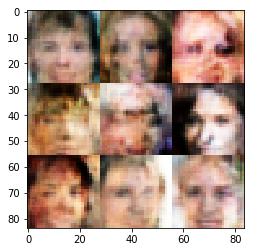

Epoch 1/1:  Discriminator Loss: 0.7043 Generator Loss: 1.1986
Epoch 1/1:  Discriminator Loss: 0.3126 Generator Loss: 1.8823
Epoch 1/1:  Discriminator Loss: 1.8624 Generator Loss: 0.2328
Epoch 1/1:  Discriminator Loss: 0.3215 Generator Loss: 1.4950
Epoch 1/1:  Discriminator Loss: 0.2931 Generator Loss: 4.2474
Epoch 1/1:  Discriminator Loss: 0.3290 Generator Loss: 2.3272
Epoch 1/1:  Discriminator Loss: 0.1176 Generator Loss: 2.6103
Epoch 1/1:  Discriminator Loss: 0.2115 Generator Loss: 4.6894
Epoch 1/1:  Discriminator Loss: 0.8937 Generator Loss: 0.7353
Epoch 1/1:  Discriminator Loss: 0.6423 Generator Loss: 1.4449


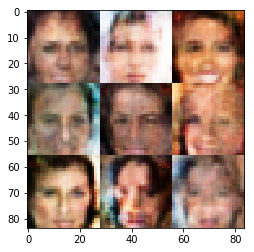

Epoch 1/1:  Discriminator Loss: 0.1789 Generator Loss: 2.8741
Epoch 1/1:  Discriminator Loss: 0.1112 Generator Loss: 2.6495
Epoch 1/1:  Discriminator Loss: 0.7014 Generator Loss: 1.8386
Epoch 1/1:  Discriminator Loss: 0.2402 Generator Loss: 2.0107
Epoch 1/1:  Discriminator Loss: 0.1148 Generator Loss: 3.8369
Epoch 1/1:  Discriminator Loss: 0.0487 Generator Loss: 4.1263
Epoch 1/1:  Discriminator Loss: 0.0433 Generator Loss: 4.8086
Epoch 1/1:  Discriminator Loss: 1.1958 Generator Loss: 3.5832
Epoch 1/1:  Discriminator Loss: 2.4174 Generator Loss: 0.1201
Epoch 1/1:  Discriminator Loss: 0.2020 Generator Loss: 3.6480


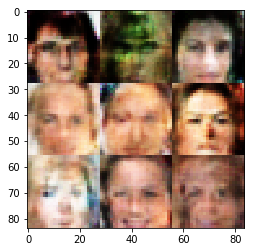

Epoch 1/1:  Discriminator Loss: 1.5262 Generator Loss: 0.5630
Epoch 1/1:  Discriminator Loss: 0.7750 Generator Loss: 2.1065
Epoch 1/1:  Discriminator Loss: 0.5127 Generator Loss: 1.2607
Epoch 1/1:  Discriminator Loss: 0.5587 Generator Loss: 1.0241
Epoch 1/1:  Discriminator Loss: 0.2211 Generator Loss: 1.9115
Epoch 1/1:  Discriminator Loss: 0.1385 Generator Loss: 4.4749
Epoch 1/1:  Discriminator Loss: 0.6941 Generator Loss: 4.4275
Epoch 1/1:  Discriminator Loss: 0.9246 Generator Loss: 0.6571
Epoch 1/1:  Discriminator Loss: 0.7054 Generator Loss: 1.1484
Epoch 1/1:  Discriminator Loss: 0.1772 Generator Loss: 2.0475


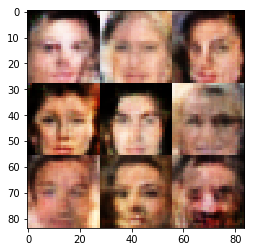

Epoch 1/1:  Discriminator Loss: 0.1087 Generator Loss: 2.9370
Epoch 1/1:  Discriminator Loss: 1.1308 Generator Loss: 0.5251
Epoch 1/1:  Discriminator Loss: 0.2058 Generator Loss: 2.1373
Epoch 1/1:  Discriminator Loss: 1.3085 Generator Loss: 2.7631
Epoch 1/1:  Discriminator Loss: 0.1022 Generator Loss: 3.4004
Epoch 1/1:  Discriminator Loss: 0.0538 Generator Loss: 4.7017
Epoch 1/1:  Discriminator Loss: 0.8433 Generator Loss: 0.7985
Epoch 1/1:  Discriminator Loss: 0.2660 Generator Loss: 3.8364
Epoch 1/1:  Discriminator Loss: 0.1132 Generator Loss: 2.6441
Epoch 1/1:  Discriminator Loss: 0.4479 Generator Loss: 1.2257


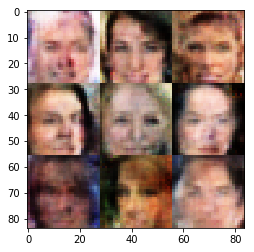

Epoch 1/1:  Discriminator Loss: 0.0837 Generator Loss: 4.0674
Epoch 1/1:  Discriminator Loss: 3.1000 Generator Loss: 4.9954
Epoch 1/1:  Discriminator Loss: 0.0956 Generator Loss: 3.6527
Epoch 1/1:  Discriminator Loss: 0.3005 Generator Loss: 4.6080
Epoch 1/1:  Discriminator Loss: 0.4684 Generator Loss: 1.6808
Epoch 1/1:  Discriminator Loss: 0.4572 Generator Loss: 1.5057
Epoch 1/1:  Discriminator Loss: 0.1115 Generator Loss: 4.4006
Epoch 1/1:  Discriminator Loss: 0.1336 Generator Loss: 2.9113
Epoch 1/1:  Discriminator Loss: 0.0660 Generator Loss: 3.6402
Epoch 1/1:  Discriminator Loss: 0.0571 Generator Loss: 3.7199


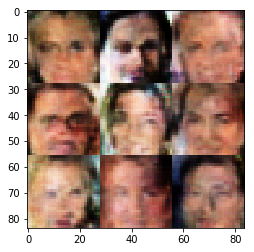

Epoch 1/1:  Discriminator Loss: 0.0314 Generator Loss: 5.3427
Epoch 1/1:  Discriminator Loss: 0.0710 Generator Loss: 5.7886
Epoch 1/1:  Discriminator Loss: 0.0201 Generator Loss: 4.8148
Epoch 1/1:  Discriminator Loss: 0.0283 Generator Loss: 4.6318
Epoch 1/1:  Discriminator Loss: 0.0170 Generator Loss: 5.9985
Epoch 1/1:  Discriminator Loss: 0.0324 Generator Loss: 4.2681
Epoch 1/1:  Discriminator Loss: 0.7334 Generator Loss: 2.1441
Epoch 1/1:  Discriminator Loss: 0.4231 Generator Loss: 2.4676
Epoch 1/1:  Discriminator Loss: 0.2102 Generator Loss: 3.2092
Epoch 1/1:  Discriminator Loss: 0.6939 Generator Loss: 1.1061


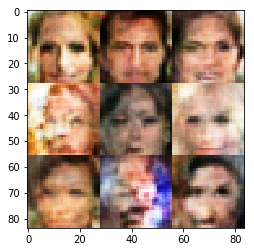

Epoch 1/1:  Discriminator Loss: 0.3602 Generator Loss: 1.7108
Epoch 1/1:  Discriminator Loss: 0.6546 Generator Loss: 4.4011
Epoch 1/1:  Discriminator Loss: 0.1394 Generator Loss: 5.0089
Epoch 1/1:  Discriminator Loss: 0.1782 Generator Loss: 2.6358
Epoch 1/1:  Discriminator Loss: 0.1806 Generator Loss: 2.0881
Epoch 1/1:  Discriminator Loss: 0.3769 Generator Loss: 1.6697
Epoch 1/1:  Discriminator Loss: 1.0984 Generator Loss: 1.5149
Epoch 1/1:  Discriminator Loss: 0.6154 Generator Loss: 1.8670
Epoch 1/1:  Discriminator Loss: 0.0635 Generator Loss: 3.4777
Epoch 1/1:  Discriminator Loss: 1.5867 Generator Loss: 3.4990


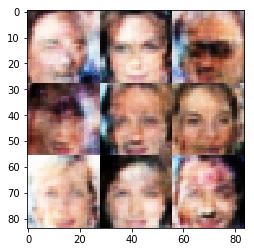

Epoch 1/1:  Discriminator Loss: 1.1011 Generator Loss: 0.5740
Epoch 1/1:  Discriminator Loss: 0.5845 Generator Loss: 1.0739
Epoch 1/1:  Discriminator Loss: 0.1497 Generator Loss: 2.8112
Epoch 1/1:  Discriminator Loss: 0.0690 Generator Loss: 3.4267
Epoch 1/1:  Discriminator Loss: 0.3171 Generator Loss: 3.2013
Epoch 1/1:  Discriminator Loss: 0.0913 Generator Loss: 2.9072
Epoch 1/1:  Discriminator Loss: 0.2132 Generator Loss: 4.4084
Epoch 1/1:  Discriminator Loss: 0.5533 Generator Loss: 1.0787
Epoch 1/1:  Discriminator Loss: 1.5284 Generator Loss: 0.3879
Epoch 1/1:  Discriminator Loss: 0.0559 Generator Loss: 4.4250


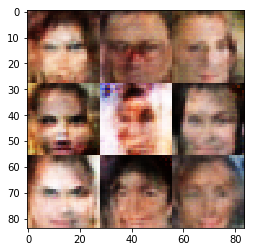

Epoch 1/1:  Discriminator Loss: 2.6370 Generator Loss: 5.0626
Epoch 1/1:  Discriminator Loss: 0.1369 Generator Loss: 3.8633
Epoch 1/1:  Discriminator Loss: 0.1046 Generator Loss: 2.7110
Epoch 1/1:  Discriminator Loss: 0.0215 Generator Loss: 5.6671
Epoch 1/1:  Discriminator Loss: 0.0332 Generator Loss: 5.1702
Epoch 1/1:  Discriminator Loss: 0.0415 Generator Loss: 4.6239
Epoch 1/1:  Discriminator Loss: 0.0375 Generator Loss: 3.8925
Epoch 1/1:  Discriminator Loss: 1.8833 Generator Loss: 0.2694
Epoch 1/1:  Discriminator Loss: 0.3829 Generator Loss: 1.7495
Epoch 1/1:  Discriminator Loss: 0.0350 Generator Loss: 4.0917


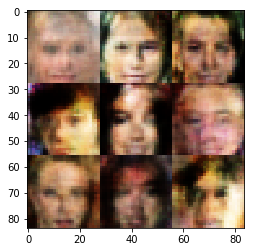

Epoch 1/1:  Discriminator Loss: 1.5005 Generator Loss: 3.0117
Epoch 1/1:  Discriminator Loss: 0.3804 Generator Loss: 2.1307
Epoch 1/1:  Discriminator Loss: 0.3937 Generator Loss: 3.6550
Epoch 1/1:  Discriminator Loss: 0.1386 Generator Loss: 3.2741
Epoch 1/1:  Discriminator Loss: 0.5655 Generator Loss: 5.0800
Epoch 1/1:  Discriminator Loss: 0.2171 Generator Loss: 2.1741
Epoch 1/1:  Discriminator Loss: 0.0801 Generator Loss: 5.5036
Epoch 1/1:  Discriminator Loss: 0.4892 Generator Loss: 3.1759
Epoch 1/1:  Discriminator Loss: 0.4736 Generator Loss: 5.0650
Epoch 1/1:  Discriminator Loss: 0.0367 Generator Loss: 5.1032


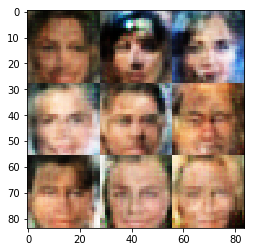

Epoch 1/1:  Discriminator Loss: 0.0834 Generator Loss: 3.0281
Epoch 1/1:  Discriminator Loss: 0.0459 Generator Loss: 4.7994
Epoch 1/1:  Discriminator Loss: 0.8194 Generator Loss: 0.7309
Epoch 1/1:  Discriminator Loss: 0.5225 Generator Loss: 2.4883
Epoch 1/1:  Discriminator Loss: 0.7886 Generator Loss: 2.8966
Epoch 1/1:  Discriminator Loss: 0.1700 Generator Loss: 3.1239
Epoch 1/1:  Discriminator Loss: 1.0242 Generator Loss: 4.0555
Epoch 1/1:  Discriminator Loss: 0.5856 Generator Loss: 4.1066
Epoch 1/1:  Discriminator Loss: 0.0359 Generator Loss: 5.1160
Epoch 1/1:  Discriminator Loss: 0.0377 Generator Loss: 4.4875


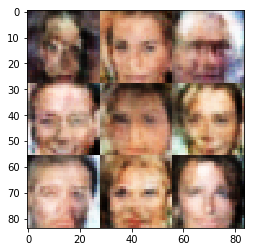

Epoch 1/1:  Discriminator Loss: 2.7006 Generator Loss: 4.6907
Epoch 1/1:  Discriminator Loss: 0.0403 Generator Loss: 4.1252
Epoch 1/1:  Discriminator Loss: 1.0305 Generator Loss: 0.7162
Epoch 1/1:  Discriminator Loss: 0.1866 Generator Loss: 2.8699
Epoch 1/1:  Discriminator Loss: 0.7232 Generator Loss: 4.8455
Epoch 1/1:  Discriminator Loss: 0.0763 Generator Loss: 4.0639
Epoch 1/1:  Discriminator Loss: 0.2402 Generator Loss: 1.8203
Epoch 1/1:  Discriminator Loss: 0.1926 Generator Loss: 6.8681
Epoch 1/1:  Discriminator Loss: 4.4790 Generator Loss: 6.2951
Epoch 1/1:  Discriminator Loss: 0.4183 Generator Loss: 1.8989


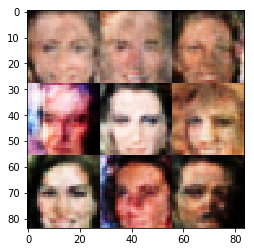

Epoch 1/1:  Discriminator Loss: 0.2766 Generator Loss: 2.0475
Epoch 1/1:  Discriminator Loss: 2.2021 Generator Loss: 5.0474
Epoch 1/1:  Discriminator Loss: 0.1980 Generator Loss: 2.1285
Epoch 1/1:  Discriminator Loss: 0.5557 Generator Loss: 4.2163
Epoch 1/1:  Discriminator Loss: 0.0411 Generator Loss: 4.2475
Epoch 1/1:  Discriminator Loss: 0.0724 Generator Loss: 3.7889
Epoch 1/1:  Discriminator Loss: 0.1436 Generator Loss: 2.4149
Epoch 1/1:  Discriminator Loss: 0.2933 Generator Loss: 1.9243
Epoch 1/1:  Discriminator Loss: 0.0998 Generator Loss: 3.5082
Epoch 1/1:  Discriminator Loss: 1.1838 Generator Loss: 0.4765


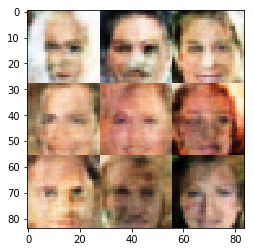

Epoch 1/1:  Discriminator Loss: 0.1535 Generator Loss: 2.4745
Epoch 1/1:  Discriminator Loss: 0.5529 Generator Loss: 2.4583
Epoch 1/1:  Discriminator Loss: 0.7545 Generator Loss: 3.1331
Epoch 1/1:  Discriminator Loss: 0.1962 Generator Loss: 3.2384
Epoch 1/1:  Discriminator Loss: 0.0711 Generator Loss: 3.9450
Epoch 1/1:  Discriminator Loss: 0.0512 Generator Loss: 3.7537
Epoch 1/1:  Discriminator Loss: 0.0327 Generator Loss: 4.4982
Epoch 1/1:  Discriminator Loss: 0.0220 Generator Loss: 5.9199
Epoch 1/1:  Discriminator Loss: 3.2378 Generator Loss: 0.0718
Epoch 1/1:  Discriminator Loss: 0.4167 Generator Loss: 1.3309


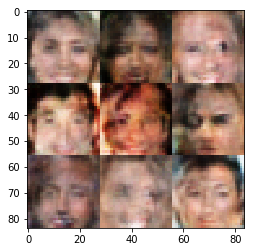

Epoch 1/1:  Discriminator Loss: 0.0440 Generator Loss: 4.4604
Epoch 1/1:  Discriminator Loss: 0.0526 Generator Loss: 3.6934
Epoch 1/1:  Discriminator Loss: 2.9823 Generator Loss: 4.9113
Epoch 1/1:  Discriminator Loss: 0.1511 Generator Loss: 4.1632
Epoch 1/1:  Discriminator Loss: 2.1855 Generator Loss: 0.1570
Epoch 1/1:  Discriminator Loss: 0.2744 Generator Loss: 2.9575
Epoch 1/1:  Discriminator Loss: 1.1694 Generator Loss: 3.4122
Epoch 1/1:  Discriminator Loss: 0.0756 Generator Loss: 3.7019
Epoch 1/1:  Discriminator Loss: 2.3356 Generator Loss: 5.6657
Epoch 1/1:  Discriminator Loss: 0.2690 Generator Loss: 2.3854


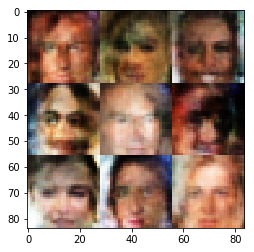

Epoch 1/1:  Discriminator Loss: 0.6803 Generator Loss: 0.9345
Epoch 1/1:  Discriminator Loss: 0.3111 Generator Loss: 4.3270
Epoch 1/1:  Discriminator Loss: 0.2196 Generator Loss: 3.9485
Epoch 1/1:  Discriminator Loss: 0.0292 Generator Loss: 5.2410
Epoch 1/1:  Discriminator Loss: 1.4217 Generator Loss: 3.9714
Epoch 1/1:  Discriminator Loss: 1.5815 Generator Loss: 0.3165
Epoch 1/1:  Discriminator Loss: 0.2052 Generator Loss: 2.4078
Epoch 1/1:  Discriminator Loss: 0.8653 Generator Loss: 3.1869
Epoch 1/1:  Discriminator Loss: 0.2182 Generator Loss: 2.8425
Epoch 1/1:  Discriminator Loss: 0.0619 Generator Loss: 3.9869


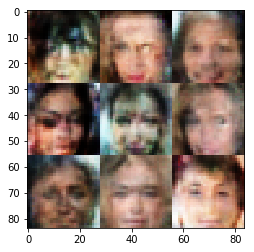

Epoch 1/1:  Discriminator Loss: 1.7085 Generator Loss: 4.5743
Epoch 1/1:  Discriminator Loss: 0.0620 Generator Loss: 4.3785
Epoch 1/1:  Discriminator Loss: 3.1807 Generator Loss: 4.9536
Epoch 1/1:  Discriminator Loss: 0.1808 Generator Loss: 2.2360
Epoch 1/1:  Discriminator Loss: 1.5827 Generator Loss: 4.3331
Epoch 1/1:  Discriminator Loss: 0.1165 Generator Loss: 2.7837
Epoch 1/1:  Discriminator Loss: 0.6437 Generator Loss: 0.9599
Epoch 1/1:  Discriminator Loss: 0.7320 Generator Loss: 0.8259
Epoch 1/1:  Discriminator Loss: 0.1535 Generator Loss: 3.7291
Epoch 1/1:  Discriminator Loss: 0.1072 Generator Loss: 2.9668


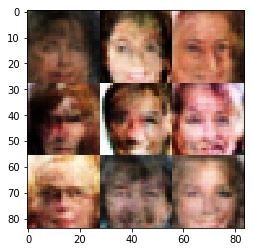

Epoch 1/1:  Discriminator Loss: 0.0882 Generator Loss: 3.1677
Epoch 1/1:  Discriminator Loss: 0.0447 Generator Loss: 3.9016
Epoch 1/1:  Discriminator Loss: 0.5697 Generator Loss: 2.8640
Epoch 1/1:  Discriminator Loss: 0.2043 Generator Loss: 3.3062
Epoch 1/1:  Discriminator Loss: 0.0754 Generator Loss: 5.0471
Epoch 1/1:  Discriminator Loss: 0.2170 Generator Loss: 6.6808
Epoch 1/1:  Discriminator Loss: 0.0795 Generator Loss: 5.4925
Epoch 1/1:  Discriminator Loss: 0.0468 Generator Loss: 3.6434
Epoch 1/1:  Discriminator Loss: 1.4263 Generator Loss: 0.4184
Epoch 1/1:  Discriminator Loss: 0.0456 Generator Loss: 4.5519


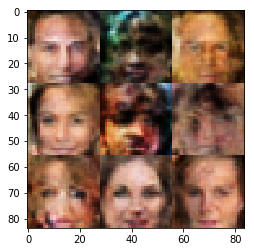

Epoch 1/1:  Discriminator Loss: 0.0909 Generator Loss: 3.6500
Epoch 1/1:  Discriminator Loss: 0.1632 Generator Loss: 4.5920
Epoch 1/1:  Discriminator Loss: 0.3913 Generator Loss: 1.5827
Epoch 1/1:  Discriminator Loss: 0.1431 Generator Loss: 2.4373
Epoch 1/1:  Discriminator Loss: 0.2062 Generator Loss: 3.0688
Epoch 1/1:  Discriminator Loss: 0.2663 Generator Loss: 6.2980
Epoch 1/1:  Discriminator Loss: 0.0324 Generator Loss: 4.8116
Epoch 1/1:  Discriminator Loss: 2.2792 Generator Loss: 0.1457
Epoch 1/1:  Discriminator Loss: 0.0653 Generator Loss: 3.1354
Epoch 1/1:  Discriminator Loss: 4.1307 Generator Loss: 0.0266


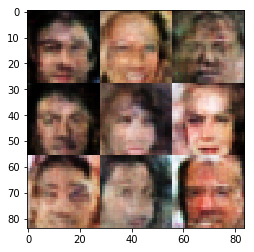

Epoch 1/1:  Discriminator Loss: 0.4768 Generator Loss: 1.8252
Epoch 1/1:  Discriminator Loss: 0.0703 Generator Loss: 3.0967
Epoch 1/1:  Discriminator Loss: 1.6567 Generator Loss: 4.4435
Epoch 1/1:  Discriminator Loss: 0.5851 Generator Loss: 4.5792
Epoch 1/1:  Discriminator Loss: 0.0402 Generator Loss: 3.9674
Epoch 1/1:  Discriminator Loss: 0.6906 Generator Loss: 1.0030
Epoch 1/1:  Discriminator Loss: 0.8257 Generator Loss: 0.8396
Epoch 1/1:  Discriminator Loss: 0.0591 Generator Loss: 3.5356
Epoch 1/1:  Discriminator Loss: 0.0446 Generator Loss: 4.4764
Epoch 1/1:  Discriminator Loss: 1.8255 Generator Loss: 0.2643


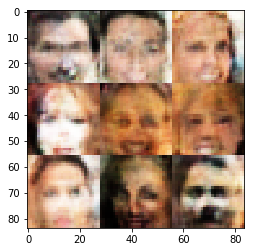

Epoch 1/1:  Discriminator Loss: 0.7881 Generator Loss: 0.9515
Epoch 1/1:  Discriminator Loss: 0.1680 Generator Loss: 2.8041
Epoch 1/1:  Discriminator Loss: 0.5192 Generator Loss: 2.7203
Epoch 1/1:  Discriminator Loss: 0.2022 Generator Loss: 3.5889
Epoch 1/1:  Discriminator Loss: 0.0613 Generator Loss: 4.0009
Epoch 1/1:  Discriminator Loss: 1.9331 Generator Loss: 0.2300
Epoch 1/1:  Discriminator Loss: 0.0770 Generator Loss: 5.1537
Epoch 1/1:  Discriminator Loss: 0.4915 Generator Loss: 4.6661
Epoch 1/1:  Discriminator Loss: 0.5978 Generator Loss: 1.8196
Epoch 1/1:  Discriminator Loss: 0.7473 Generator Loss: 0.8138


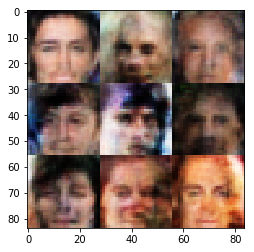

Epoch 1/1:  Discriminator Loss: 0.4826 Generator Loss: 1.3329
Epoch 1/1:  Discriminator Loss: 0.4445 Generator Loss: 1.3489
Epoch 1/1:  Discriminator Loss: 0.7906 Generator Loss: 0.9050
Epoch 1/1:  Discriminator Loss: 0.6393 Generator Loss: 2.5510
Epoch 1/1:  Discriminator Loss: 0.5308 Generator Loss: 6.3994
Epoch 1/1:  Discriminator Loss: 0.4240 Generator Loss: 1.9053
Epoch 1/1:  Discriminator Loss: 0.4800 Generator Loss: 1.2789
Epoch 1/1:  Discriminator Loss: 0.2663 Generator Loss: 5.1307
Epoch 1/1:  Discriminator Loss: 0.1173 Generator Loss: 2.9305
Epoch 1/1:  Discriminator Loss: 2.2688 Generator Loss: 0.1652


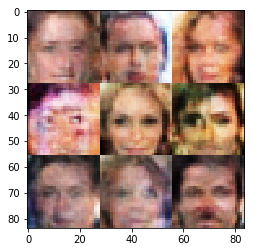

Epoch 1/1:  Discriminator Loss: 0.0314 Generator Loss: 4.4188
Epoch 1/1:  Discriminator Loss: 0.1027 Generator Loss: 2.8488
Epoch 1/1:  Discriminator Loss: 0.0377 Generator Loss: 5.3388
Epoch 1/1:  Discriminator Loss: 0.1441 Generator Loss: 2.4402
Epoch 1/1:  Discriminator Loss: 4.8468 Generator Loss: 8.2380
Epoch 1/1:  Discriminator Loss: 0.0968 Generator Loss: 3.8107
Epoch 1/1:  Discriminator Loss: 0.0681 Generator Loss: 3.4947
Epoch 1/1:  Discriminator Loss: 2.2220 Generator Loss: 0.1634
Epoch 1/1:  Discriminator Loss: 0.2514 Generator Loss: 2.0002
Epoch 1/1:  Discriminator Loss: 0.0745 Generator Loss: 3.0255


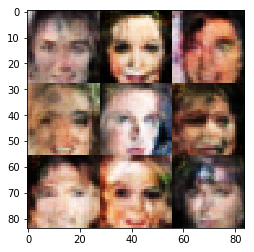

Epoch 1/1:  Discriminator Loss: 0.1038 Generator Loss: 3.2254
Epoch 1/1:  Discriminator Loss: 0.0434 Generator Loss: 4.6608
Epoch 1/1:  Discriminator Loss: 0.0304 Generator Loss: 6.6208
Epoch 1/1:  Discriminator Loss: 0.1876 Generator Loss: 2.1339
Epoch 1/1:  Discriminator Loss: 0.0103 Generator Loss: 5.4522
Epoch 1/1:  Discriminator Loss: 0.0231 Generator Loss: 7.1633
Epoch 1/1:  Discriminator Loss: 2.4517 Generator Loss: 0.1317
Epoch 1/1:  Discriminator Loss: 0.5374 Generator Loss: 1.1648
Epoch 1/1:  Discriminator Loss: 0.6003 Generator Loss: 1.2666
Epoch 1/1:  Discriminator Loss: 0.8134 Generator Loss: 0.7053


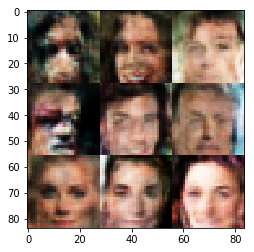

Epoch 1/1:  Discriminator Loss: 0.7108 Generator Loss: 3.9876
Epoch 1/1:  Discriminator Loss: 0.1873 Generator Loss: 2.5672
Epoch 1/1:  Discriminator Loss: 0.3764 Generator Loss: 1.4252
Epoch 1/1:  Discriminator Loss: 0.0537 Generator Loss: 3.9967
Epoch 1/1:  Discriminator Loss: 0.0241 Generator Loss: 6.1229
Epoch 1/1:  Discriminator Loss: 1.3211 Generator Loss: 0.4112
Epoch 1/1:  Discriminator Loss: 0.5683 Generator Loss: 1.0436
Epoch 1/1:  Discriminator Loss: 0.1433 Generator Loss: 3.1186
Epoch 1/1:  Discriminator Loss: 0.1994 Generator Loss: 3.0063
Epoch 1/1:  Discriminator Loss: 0.0869 Generator Loss: 3.2178


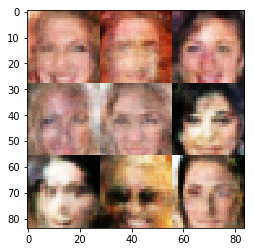

Epoch 1/1:  Discriminator Loss: 0.0524 Generator Loss: 3.6863
Epoch 1/1:  Discriminator Loss: 0.0357 Generator Loss: 3.9249
Epoch 1/1:  Discriminator Loss: 0.1774 Generator Loss: 2.6467
Epoch 1/1:  Discriminator Loss: 0.3062 Generator Loss: 5.5694
Epoch 1/1:  Discriminator Loss: 0.9383 Generator Loss: 5.5760
Epoch 1/1:  Discriminator Loss: 0.3713 Generator Loss: 2.7205
Epoch 1/1:  Discriminator Loss: 0.1985 Generator Loss: 3.3963
Epoch 1/1:  Discriminator Loss: 1.3308 Generator Loss: 0.4995
Epoch 1/1:  Discriminator Loss: 0.0989 Generator Loss: 2.6909
Epoch 1/1:  Discriminator Loss: 0.0225 Generator Loss: 4.4266


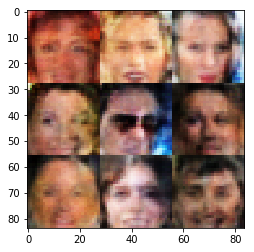

Epoch 1/1:  Discriminator Loss: 0.0337 Generator Loss: 5.3659
Epoch 1/1:  Discriminator Loss: 1.8809 Generator Loss: 0.3649
Epoch 1/1:  Discriminator Loss: 0.8073 Generator Loss: 0.7163
Epoch 1/1:  Discriminator Loss: 1.5674 Generator Loss: 0.3127
Epoch 1/1:  Discriminator Loss: 1.0119 Generator Loss: 5.3663
Epoch 1/1:  Discriminator Loss: 0.0255 Generator Loss: 5.2469
Epoch 1/1:  Discriminator Loss: 0.4564 Generator Loss: 1.1478
Epoch 1/1:  Discriminator Loss: 0.8308 Generator Loss: 0.8116
Epoch 1/1:  Discriminator Loss: 0.5832 Generator Loss: 1.1678
Epoch 1/1:  Discriminator Loss: 1.4478 Generator Loss: 0.4058


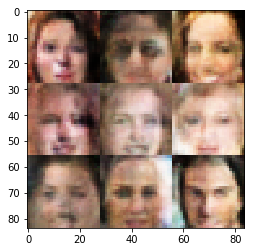

Epoch 1/1:  Discriminator Loss: 0.0421 Generator Loss: 4.1318
Epoch 1/1:  Discriminator Loss: 0.9484 Generator Loss: 6.2057
Epoch 1/1:  Discriminator Loss: 0.8897 Generator Loss: 6.8133


In [54]:
batch_size = 32
z_dim = 32
learning_rate = 0.0005
beta1 = 0.05


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.